#Gradient Descent und Neuronale Netze
## Klassifizierung von MNIST Bildern


In diesem Notebook werden wir das MNIST Datenset betrachten und mithilfe von NumPy ein neuronales Netzwerk trainieren, um Bilder korrekt zu klassifizieren. 

## 1. Aufgabe: Datensatz
Zuerst betrachten wir den Datensatz etwas genauer.

In [ ]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina' # for better quality plots


# Laden des Trainingsdatensatzes von MNIST
train_data = datasets.MNIST(root='./data', train=True, download=True)
# Laden des Testdatensatzes von MNIST
test_data = datasets.MNIST(root='./data', train=False, download=True)

# Anzeigen der Anzahl der Bilder und ihrer Größe
print("Anzahl der Trainingsbilder:", len(train_data))
print("Anzahl der Testbilder:", len(test_data))
print("Größe eines Bildes:", train_data[0][0].size)


Anzahl der Trainingsbilder: 60000
Anzahl der Testbilder: 10000
Größe eines Bildes: (28, 28)


Wir betrachten ein Paar Datenobjekte, um uns mit dem Datensatz vertraut zu machen.

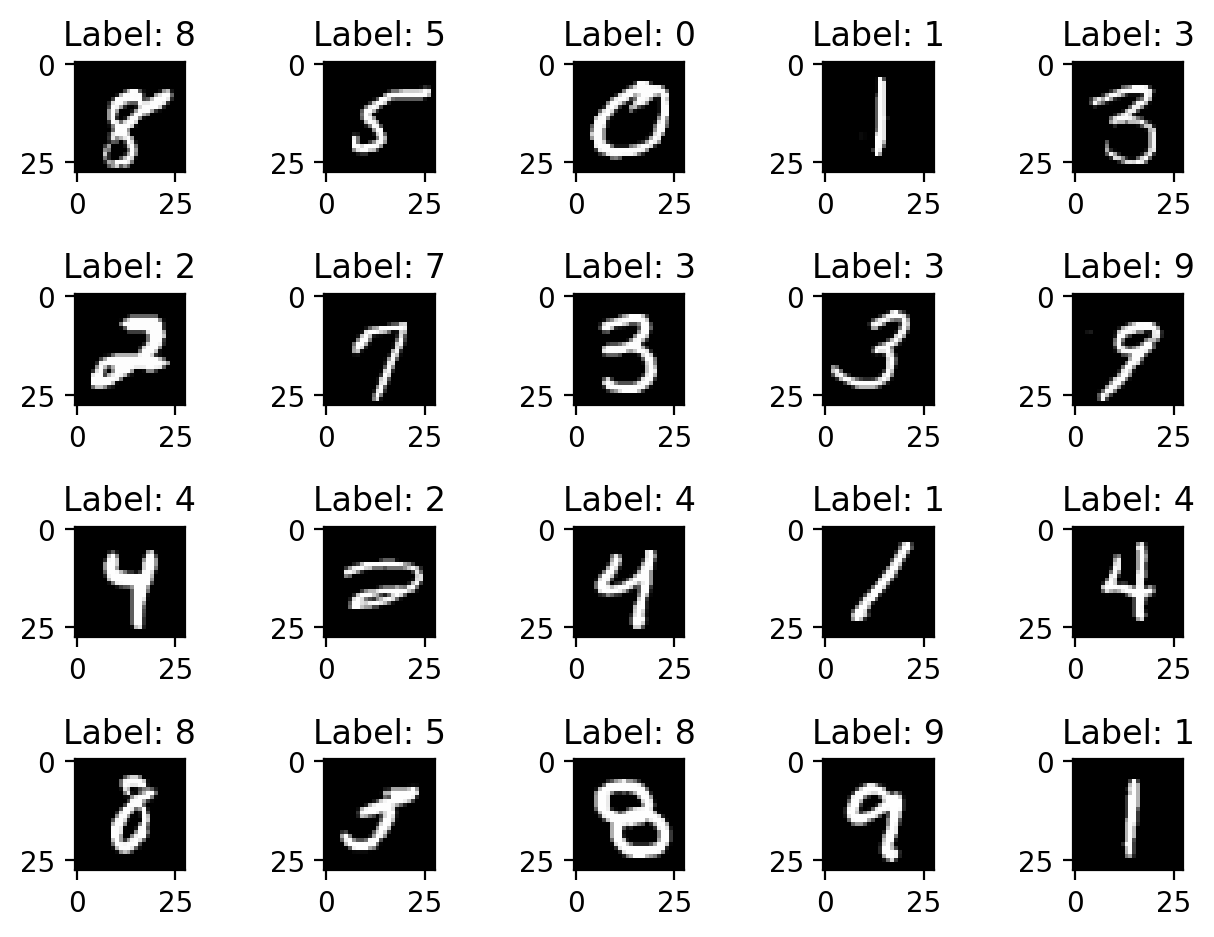

In [ ]:
# Anzeigen einiger zufaellig ausgewaehlter Beispielbilder mit Label
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols)
for i in range(n_rows):
    for j in range(n_cols):
        random_idx = np.random.randint(0, len(train_data) - 1)
        img, label = train_data[random_idx]
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title("Label: {}".format(label))
plt.tight_layout()
plt.show()

Ausserdem betrachten wir die Haeufigkeit der verschiedenen label.

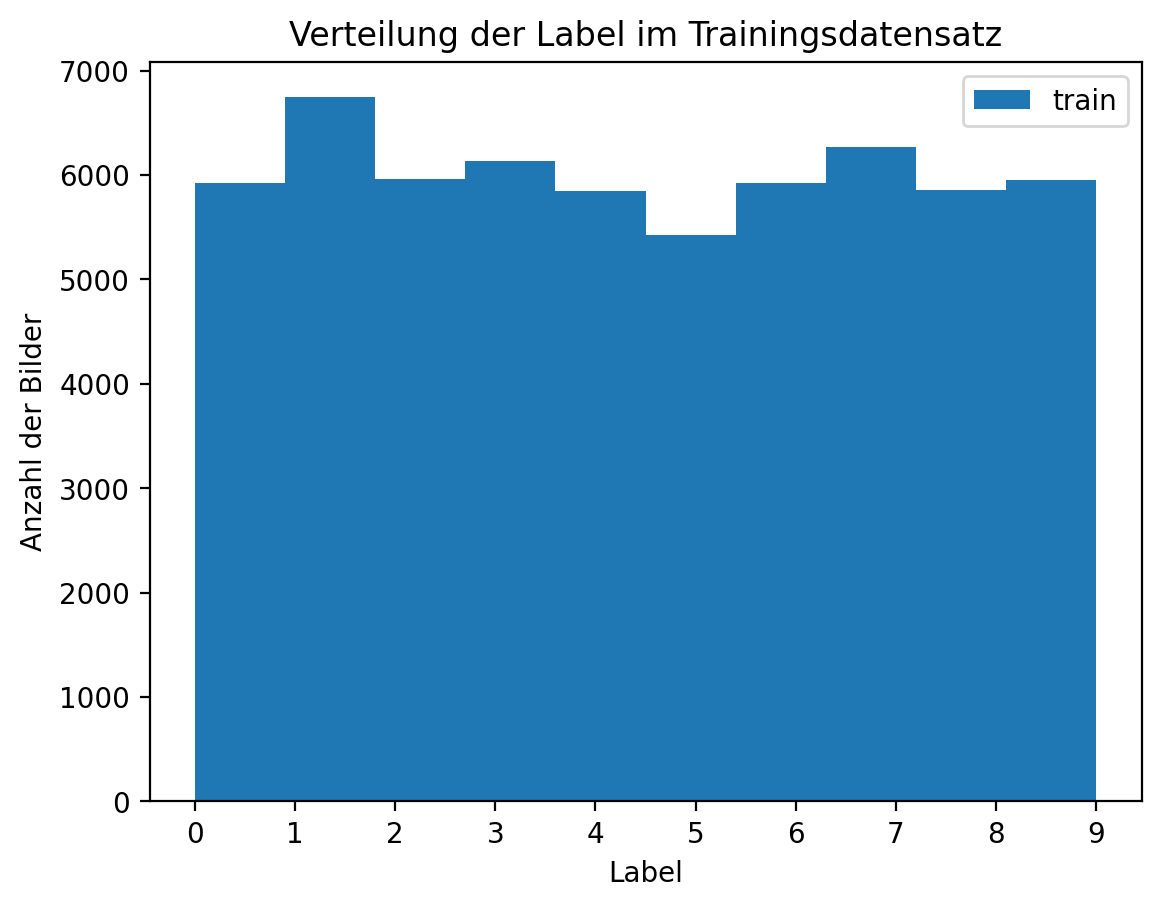

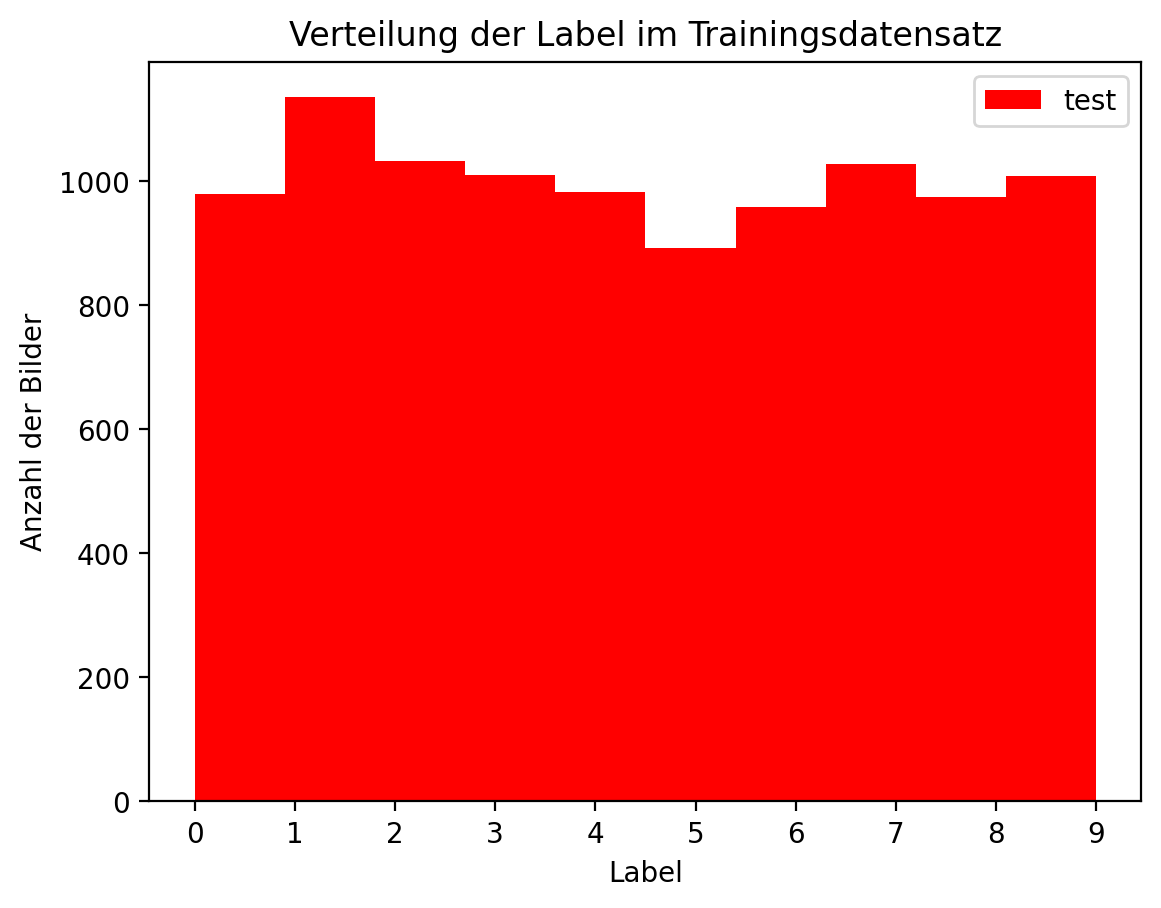

In [ ]:
# Erstellen eines Histogramms der Label
labels = [data[1] for data in train_data]
plt.hist(labels, bins=10, label="train")
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Label im Trainingsdatensatz')
plt.legend()
plt.show()

# Erstellen eines Histogramms der Label
labels = [data[1] for data in test_data]
plt.hist(labels, bins=10, label="test", color="r")
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Label im Trainingsdatensatz')
plt.legend()
plt.show()


*   Datensatz von 70.000 Bildern, 60.000 Training, 10.000 Test
*   Bilder haben 28x28 Pixel und einen Farbchannel (Schwarz\Weiss)
*   Bilder Zeigen handgeschriebene Ziffern
*   Jedes Bild kommt mit einem Label entsprechend der abgebildeten Ziffer
*   Die Verteilung der Label ist recht gut balanciert


## 2. Aufgabe: Linear Layer
Nun implementieren wir einen Linear Layer mit numpy.

Input: x: Vektor mit $n$ floats

Output: y: Vektor mit $m$ floats

Ein Wert (Knoten) im Output wird berechnet, indem jeder Inputwert mit einem individuellen Gewicht malgenommen und aufsummiert wird. Zus"atzlich erh"alt jeder Knoten einen Bias, der dieser gewichteten Summe hinzuaddiert wird, um den Output zu erhalten.
In Vektorschreibweise:

Forward-Schritt:
\begin{equation}
y = \mathbf{W} \cdot x + \mathbf{b}
\end{equation}

$\boldsymbol{x} \in \mathbb{R}^{n}$ der Eingabevektor,
$\boldsymbol{W} \in \mathbb{R}^{m \times n}$ die Gewichtsmatrix,
$\boldsymbol{b} \in \mathbb{R}^{m}$ der Bias-Vektor,
$\boldsymbol{y} \in \mathbb{R}^{m}$ der Ausgabevektor.


Mit dem Output wird dann ein Loss $\textbf{L}$ berechnet.
Die (negative) Ableitung des Loss nach dem Output $\frac{\partial \textbf{L}}{\partial y}$ zeigt, welche Veränderung im Output zu geringerem Loss führt.
Der Backward-Schritt berechnet darauf basierend geeignete Richtungen, um die weights und biases upzudaten.
Da normalerweise mehrere Linear Layer aneinander gehängt werden, ist der Input dieses Layers viellecht der Output eines anderen Layers, ist die Ableitung des Loss nach dem Input $\frac{\partial \textbf{L}}{\partial x}$ die Basis, auf der dessen updates berechnet werden.

Backward-Schritt:
$$\frac{\partial \textbf{L}}{\partial x} = \mathbf{W}^\top \frac{\partial \textbf{L}}{\partial y}$$
$$\frac{\partial \textbf{L}}{\partial \mathbf{W}} = \frac{\partial \textbf{L}}{\partial y} x^\top$$
$$\frac{\partial \textbf{L}}{\partial \mathbf{b}} = \sum_{i} \frac{\partial \textbf{L}}{\partial y_i}$$



Update-Schritt:
\begin{equation}
\mathbf{W} \leftarrow \mathbf{W} - \alpha \frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{b} \leftarrow \mathbf{b} - \alpha \frac{\partial L}{\partial \mathbf{b}}
\end{equation}

Die Lernrate $\alpha$ muss dabei geschickt gewählt werden. Die richtige Wahl hängt von vielen Faktoren ab und muss im Einzelfall durch ausprobieren bestimmt werden.

In [ ]:
import numpy as np

class LinearLayer:
    def __init__(self, in_dim: int, out_dim: int) -> None:
        """ Initialize the weights randomly using a normal distribution
            with mean 0 and standard deviation 1 and set the bias to 0.
            Initialize instance variables for the inputs, outputs, and gradients."""
        self.weights = np.random.randn(out_dim, in_dim)
        self.weights /= self.weights.sum()  # this makes sure that the forward does not explode at first shot
        self.bias = np.zeros((out_dim, 1))
        self.inputs = None
        self.outputs = None
        self.d_weights = None
        self.d_bias = None
        
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        """ Save the inputs and compute the outputs by multiplying the inputs
            by the weights and adding the bias."""
        self.inputs = inputs
        self.outputs = np.dot(self.weights, self.inputs) + self.bias
        return self.outputs  # this is the input for the next layer

    def backward(self, d_outputs: np.ndarray) -> np.ndarray:
        """ Compute the gradients with respect to the inputs, weights, and bias
            based on the gradient of the loss with respect to the layer's outputs."""
        # d_outputs is dL/dy
        d_inputs = np.dot(self.weights.T, d_outputs)  # dL/dx
        self.d_weights = np.dot(d_outputs, self.inputs.T)  # dL/dW
        self.d_bias = np.sum(d_outputs, axis=1, keepdims=True)  # dL/db
        return d_inputs  # this is d_outputs for the previous layer

    def update(self, lr: float) -> None:
        """ Update the weights and bias using the gradients and a learning rate."""
        self.weights -= lr * self.d_weights
        self.bias -= lr * self.d_bias


Um zu pruefen, ob der Code fehlerfrei funktioniert, schreiben wir ein paar Unittests. Diese tests pruefen zunaechst, ob die outputs das richtige Format haben. Dann folgt ein Test, der die Berechnung ueberprueft, idealerweise mit randomisierten Zahlen (auch feste Zahlenwerte sind okay). Wichtig ist, dass mit mehr als einem Datenpunkt getestet wird.

In [ ]:
from numpy.testing import assert_allclose

class TestLinearLayer:
    # First, test shapes. Useful for debugging, but not mandatory
    def test_forward(self):
        # Test the forward pass of the LinearLayer object with two input data points.
        layer = LinearLayer(3, 2)
        inputs = np.random.randn(3, 2)  # Two input data points
        outputs = layer.forward(inputs)
        assert outputs.shape == (2, 2)
        
    def test_backward(self):
        # Test the backward pass of the LinearLayer object with two input data points and two output gradients.
        layer = LinearLayer(3, 2)
        inputs = np.random.randn(3, 2)  # Two input data points
        layer.forward(inputs)
        d_outputs = np.random.randn(2, 2)  # Two output gradients
        d_inputs = layer.backward(d_outputs)
        assert d_inputs.shape == (3, 2)
        assert layer.d_weights.shape == (2, 3)
        assert layer.d_bias.shape == (2, 1)
        
    def test_update(self):
        # Test the weight and bias updates of the LinearLayer object using a specified learning rate.
        layer = LinearLayer(3, 2)
        old_weights = layer.weights.copy()
        old_bias = layer.bias.copy()
        layer.d_weights = np.random.randn(2, 3)
        layer.d_bias = np.random.randn(2, 1)
        lr = 0.01
        layer.update(lr)
        new_weights = layer.weights
        new_bias = layer.bias
        assert_allclose(new_weights, old_weights - lr * layer.d_weights)
        assert_allclose(new_bias, old_bias - lr * layer.d_bias)
        
        
    def test_forward_backward(self):
        # Test the consistency of the forward and backward passes of the LinearLayer object with two input data points and two output gradients.
        layer = LinearLayer(3, 2)
        inputs = np.random.randn(3, 2)
        outputs = layer.forward(inputs)
        d_outputs = np.random.randn(2, 2)
        d_inputs = layer.backward(d_outputs)
        assert_allclose(np.dot(layer.weights.T, d_outputs), d_inputs)

    # MANDATORY TEST: test with at least two datapoints
    # test can be probabilistic or with known input and weights
    def test_probabilistic_forward_backward_update(self):
        """ test whether all computations are done correctly """
        # Generate random inputs, weights, biases, and output gradients
        inputs = np.random.randn(3, 2)
        weights = np.random.randn(2, 3)
        bias = np.random.randn(2, 1)
        d_outputs = np.random.randn(2, 2)

        # Manually perform forward, backward, and update steps
        outputs_manual = np.dot(weights, inputs) + bias
        d_inputs_manual = np.dot(weights.T, d_outputs)
        d_weights_manual = np.dot(d_outputs, inputs.T)
        d_bias_manual = np.sum(d_outputs, axis=1, keepdims=True)
        lr = 0.01
        weights_manual_updated = weights - lr * d_weights_manual
        bias_manual_updated = bias - lr * d_bias_manual

        # Perform forward, backward, and update steps using LinearLayer class
        layer = LinearLayer(3, 2)
        layer.weights = weights.copy()
        layer.bias = bias.copy()
        outputs = layer.forward(inputs)
        d_inputs = layer.backward(d_outputs)
        layer.update(lr)

        # Check if the results match
        assert_allclose(outputs, outputs_manual)
        assert_allclose(d_inputs, d_inputs_manual)
        assert_allclose(layer.weights, weights_manual_updated)
        assert_allclose(layer.bias, bias_manual_updated)

test = TestLinearLayer()
test.test_forward()
test.test_backward()
test.test_update()
test.test_forward_backward()
test.test_probabilistic_forward_backward_update()
print("All tests passed!")


All tests passed!


## 3. Aufgabe: Neuronales Netz

Nun erstellen wir ein Neuronales Netzwerk mit einem hidden Layer mithilfe von numpy.
Damit besteht es aus zwei Linear Layern: einem hidden Layer, welches die Bilddaten nimmt, dessen output wir aber nicht sehen. Dieser dient als Input fuer das naechste Output layer, dessen output die Vorhersage ist.
Dieser Prozess wird im forward definiert.

Im Backward wird basierend auf der Ableitung einer Loss Funktion nach dem Output, Layer für Layer, die Ableitung für die weights und biases berechnet und in update angewendet.

Für das Training erstellt das Modell Vorhersagen für die Klassen aller Bilder.
Darauf wird durch den Vergleich mit den tatsächlichen Klassen ein Loss berechnet.
Die Ableitung dieses Loss wird dann im Backward Pass fuer alle weights und biases berechnet und diese entsprechend geupdated.

Um den Fortschitt der Funktion zu verfolgen, berechnet test den Loss auf dem Testset.

In [ ]:
class NeuralNetwork:
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """Initialize a neural network with given input, hidden and output layer sizes."""
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_layer = LinearLayer(input_size, hidden_size)
        self.output_layer = LinearLayer(hidden_size, output_size)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Perform a forward pass through the neural network given input x."""
        x = self.hidden_layer.forward(x)
        x = relu(x)  # not mandatory
        x = self.output_layer.forward(x)
        x = sigmoid(x) # has to match the target. here sigmoid -> [0,1], target is 0 (not a 4) or 1 (a 4)
        return x

    def backward(self, d_outputs: np.ndarray) -> None:
        """Perform a backward pass through the neural network given derivative of the loss w.r.t output."""
        d_hidden_outputs = self.output_layer.backward(d_outputs)
        d_hidden_outputs_relu = np.where(self.hidden_layer.forward(self.hidden_layer.inputs) > 0, d_hidden_outputs, 0)
        self.hidden_layer.backward(d_hidden_outputs_relu)
        self.output_layer.backward(d_outputs)

    def update(self, learning_rate: float) -> None:
        """Update the weights of the neural network with the given learning rate."""
        self.hidden_layer.update(learning_rate)
        self.output_layer.update(learning_rate)

    def train(self, inputs: np.ndarray, targets: np.ndarray, learning_rate: float, loss_function) -> float:
        """Train the neural network with the given inputs and targets using the given loss function and learning rate."""
        outputs = self.forward(inputs)
        loss = loss_function(outputs, targets)
        d_outputs = loss_function.derivative(outputs, targets)
        self.backward(d_outputs)
        self.update(learning_rate)
        return loss

    def test(self, inputs: np.ndarray, targets: np.ndarray, loss_function, print_prediction: bool = False) -> float:
        """Test the neural network with the given inputs and targets using the given loss function and return the loss."""
        outputs = self.forward(inputs)
        if print_prediction:
            print("prediction min,max", outputs.min(), outputs.max())
        loss = loss_function(outputs, targets)
        return loss



def relu(x: np.ndarray) -> np.ndarray:
    """ Berechnet die ReLU Funktion auf den Eingabewerten. """
    return np.maximum(0, x)


def sigmoid(x: np.ndarray) -> np.ndarray:
    """Berechnet die Sigmoid Funktion auf den Eingabewerten."""
    x_clipped = np.clip(x, -500, 500)  # Limit the range of input values to prevent numerical errors
    return 1 / (1 + np.exp(-x_clipped))


Eine geeignete Loss-Funktion für eine binäre Klassifikation ist die Binary Cross Entropy Loss oder kurz BCE Loss. Diese Loss-Funktion wird verwendet, um die Differenz zwischen der tatsächlichen Wahrscheinlichkeit und der Vorhersage des Modells zu messen. Die BCE Loss ist definiert als:

$BCELoss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$

wobei $y_i$ das tatsächliche Label des i-ten Datenpunkts ist und $\hat{y}_i$ die Vorhersage des Modells. Die Summe wird über alle N Datenpunkte berechnet. Die BCE Loss wird minimiert, wenn das Modell eine perfekte Vorhersage trifft (d.h. wenn $\hat{y}_i = y_i$ für alle i), und wird grösser, je weiter $\hat{y}_i$ von $y_i$ entfernt ist).


Der Binary Cross Entropy (BCE) Loss ist eine geeignete Verlustfunktion für binäre Klassifikationsprobleme, da er effektiv Abweichungen zwischen den tatsächlichen und den vorhergesagten Wahrscheinlichkeiten misst und große Abweichungen stark bestraft. Im Gegensatz dazu kann der Mean Squared Error (MSE) Loss bei binären Klassifikationsproblemen empfindlicher gegenüber kleinen Fehlern sein und zu langsameren Konvergenzraten führen.

Der Hinge Loss, der in Support Vector Machines eingesetzt wird, ist ebenfalls eine effektive Verlustfunktion für binäre Klassifikationsprobleme. Im Gegensatz zum BCE Loss konzentriert sich der Hinge Loss auf die Optimierung der Entscheidungsgrenze und zielt darauf ab, den Abstand zwischen den Klassen zu maximieren. Es ist wichtig zu beachten, dass der Hinge Loss die Wahrscheinlichkeiten nicht direkt schätzt, was in bestimmten Anwendungen eine Einschränkung sein kann.

Zusammenfassend ist der BCE Loss eine gute Wahl für binäre Klassifikationsprobleme, während der MSE Loss und der Hinge Loss ihre eigenen Vorteile bieten. Die Eignung der Verlustfunktionen hängt von der spezifischen Anwendung und den Anforderungen ab, sodass keine der Verlustfunktionen als grundsätzlich überlegen betrachtet werden kann.

In [ ]:
import numpy as np

class BCELoss:
    def __init__(self):
        pass
        
    def forward(self, inputs: np.ndarray, targets: np.ndarray, eps: float = 1e-8) -> float:
        """
        Berechnet den BCE Loss.
        Args:
            inputs (numpy array): Die Vorhersagen des Modells.
            targets (numpy array): Die tatsächlichen Labels.
            imbalance (int): factor for weighing 1 targets. Important when the class is imbalanced.
        Returns:
            Der Wert des BCE Loss.
        """
        loss = -np.mean(targets * np.log(inputs + eps) + (1 - targets) * np.log(1 - inputs + eps)) # add small eps to prevent log(0)
        return loss
        
    def derivative(self, inputs: np.ndarray, targets: np.ndarray, eps: float = 1e-8) -> np.ndarray:
        """
        Berechnet die Ableitung des BCE Loss.
        Args:
            inputs (numpy array): Die Vorhersagen des Modells.
            targets (numpy array): Die tatsächlichen Labels.
        Returns:
            Die Ableitung des BCE Loss.
        """
        N = inputs.shape[1]
        derivative = (inputs - targets) / (inputs * (1 - inputs) + eps) / N  ## add small number to omit division by 0
        return derivative


    def __call__(self, inputs: np.ndarray, targets: np.ndarray) -> float:
        """
        Berechnet den BCE Loss.
        Args:
            inputs (numpy array): Die Vorhersagen des Modells.
            targets (numpy array): Die tatsächlichen Labels.
        Returns:
            Der Wert des BCE Loss.
        """
        return self.forward(inputs, targets)

Der F1-Score ist eine gute Wahl, um die Identifikation von Bildern mit der Ziffer 4 im MNIST-Datensatz zu evaluieren, da er eine ausgewogene Metrik ist, die sowohl Precision als auch Recall berücksichtigt. Dies ist wichtig, weil bei der Identifizierung von Bildern mit der Ziffer 4 sowohl falsch-positive als auch falsch-negative Vorhersagen problematisch sein können. 

\begin{align}
F1\text{-}Score &= \frac{2 \cdot Precision \cdot Recall}{Precision + Recall} \\
Precision &= \frac{\text{True Positives}}{\text{True Positives + False Positives}} \\
Recall &= \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
\end{align}


Im Gegensatz zum  F1-Score, der die falsch-positiven und falsch-negativen Vorhersagen berücksichtigt, misst die Accuracy Anteil der korrekten Vorhersagen.
Die Accuracy kann täuschen, wenn die Klassen nicht ausgewogen sind. Da 90% der Bilder im Datensatz keine 4 sind, wird ein Klassifikator, der immer "keine 4" vorhersagt, eine hohe Accuracy erzielen, obwohl er keine 4er-Bilder erkennt. Der F1-Score ist hingegen unabhängig von der Klassenverteilung und gibt eine genaue Bewertung der Leistung des Klassifikators.

In [ ]:
import numpy as np

def precision(tp: int, fp: int) -> float:
    """ Berechnet precision aus True Positives (tp) und False Positives (fp) """
    if not (tp or fp): return 0  # Verhindere teilen durch 0
    precision = tp / (tp + fp)
    return precision
    
def recall(tp: int, fn: int) -> float:
    """ Berechnet Recall aus True Positives (tp) und False negatives (fn) """
    if not (tp or fn): return 0  # Verhindere teilen durch 0
    recall = tp / (tp + fn)
    return recall
    
def f1_score(tp: int, fp: int, fn: int) -> float:
    """
    Berechnet den F1-Score aus den True Positives (tp), False Positives (fp)
    und False Negatives (fn).
    """
    prec = precision(tp, fp)
    rec = recall(tp, fn)
    if not (rec or prec): return 0.  # Verhindere teilen durch 0
    f1_score = 2 * prec * rec / (prec + rec)
    return f1_score


## 4. Aufgabe: Trainieren

Nun trainieren wir dieses Neuronale Netzwerk darauf, Bilder von vieren im MNIST Dataset zu identifizieren. Dafür müssen die Daten zunächst vorbereitet werden:
* die Label umwandeln: 0-9 zu 1 wenn 4 und 0 sonst
* die Bilddaten für LinearLayer vorbereiten (2D Bild -> 1D Vektor)
* Bilder auf 0-1 normieren, um Performance zu verbessern

In [ ]:
def preprocess_data(data: datasets) -> tuple:
    """
    Preprocesses image data by converting images to numpy arrays, reshaping them,
    normalizing pixel values, converting labels to binary classification and returning images and labels as tuple
    """
    images = np.array([np.array(x) for x in data.data])
    images = images.reshape(images.shape[0], -1)  # shape: (N,x,y) -> (N,x*y)
    images = images / 255.0
    images = images.T  ## LinearLayer assumes input shape = (input_size, N_batch)
    labels = np.array(data.targets)
    labels = np.where(labels == 4, 1, 0)
    return images, labels


Nun wollen wir dieses Modell mit mehreren zufällig ausgewählten Hyperparametern (learning rate, hidden size) trainieren und die Parameter mit der besten Performance wählen. Es ist auch sinnvoll, ein Gitter von Hyperparametern zu testen.


In [ ]:

def train_and_evaluate(num_hyperparams: int, num_epochs: int, train_data: datasets, test_data: datasets, print_prediction=False) -> tuple:
    """
    Trains and evaluates a neural network on given train and test data, using a range of hyperparameters.

    Args:
        num_hyperparams (int): Number of different hyperparameters to evaluate the model with.
        num_epochs (int): Number of epochs to train the model for.
        train_data: Data to train the model on.
        test_data: Data to evaluate the trained model on.
        print_prediction (bool, optional): Whether to print predicted labels during testing. Defaults to False.

    Returns:
        tuple: A tuple containing hyperparameters, training losses, testing losses, and testing metrics.
               The first element is a list of dictionaries, where each dictionary contains the hyperparameters for a single model.
               The second and third elements are lists of lists containing the training and testing losses for each epoch of each model.
               The fourth element is a list containing three sub-lists, each of which contains the precision, recall, and F1 score for each epoch of each model, respectively.
    """
    train_losses, test_losses, test_precisions, test_recalls, test_f1_scores = [], [], [], [], []
    hyperparameters = []

    train_images, train_labels = preprocess_data(train_data)
    test_images, test_labels = preprocess_data(test_data)

    for run in range(num_hyperparams):
        learning_rate = 10 ** np.random.uniform(-3, -1)
        hidden_size = np.random.choice([64, 128, 256])

        input_size = train_images.shape[0]
        output_size = 1

        hp = {
            "lr": learning_rate,
            "n_h": hidden_size,
        }
        hyperparameters.append(hp)
        print(hp)

        model = NeuralNetwork(input_size, hidden_size, output_size)
        loss_function = BCELoss()

        train_loss_history = []
        test_loss_history = []
        test_precision_history = []
        test_recall_history = []
        test_f1_history = []

        for epoch in range(num_epochs):
            # evaluate the model before training -> train and test loss refer to same state of the model
            test_loss = model.test(test_images, test_labels, loss_function, print_prediction=print_prediction)
            tp, fp, fn = calculate_tp_fp_fn(model, test_images, test_labels)
            test_precision = precision(tp, fp)
            test_recall = recall(tp, fn)
            test_f1 = f1_score(tp, fp, fn)
            train_loss = model.train(train_images, train_labels, learning_rate, loss_function)

            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)
            test_precision_history.append(test_precision)
            test_recall_history.append(test_recall)
            test_f1_history.append(test_f1)

        train_losses.append(train_loss_history)
        test_losses.append(test_loss_history)
        test_precisions.append(test_precision_history)
        test_recalls.append(test_recall_history)
        test_f1_scores.append(test_f1_history)

    test_metrics = [test_precisions, test_recalls, test_f1_scores]
    return hyperparameters, train_losses, test_losses, test_metrics


def calculate_tp_fp_fn(model: NeuralNetwork, images: np.ndarray, labels: np.ndarray) -> tuple:
    """Calculates true positives (tp), false positives (fp), and false negatives (fn) for a given neural network model, """
    predictions = (model.forward(images) > 0.5).astype(int).flatten()
    tp = np.sum((predictions == 1) & (labels == 1))
    fp = np.sum((predictions == 1) & (labels == 0))
    fn = np.sum((predictions == 0) & (labels == 1))
    return tp, fp, fn



Um die verschiedenen runs einfach miteinander zu vergleichen, plotten wir für jeden der verschiedenen Losses und Evaluationsmetriken ein Bild, welches die Resultate aller runs zeigt.
Die Beste Wahl von Hyperparametern erreicht den geringsten test loss und die besten Evaluationsmetriken in der geringsten Anzahl von Epochen.

In [ ]:
def plot_results(train_losses: list, test_losses: list, test_metrics: list, hyperparams: list):
    """ Plots the results of training and evaluating a neural network model with a range of hyperparameters"""
    plt.figure(figsize=(16, 9))

    labels = [f'{", ".join([f"{key}:{val:.3g}" for key,val in hp.items()])}' for hp in hyperparams]


    # Plot train loss for all runs
    plt.subplot(3, 2, 1)
    for train_loss, label in zip(train_losses, labels):
        plt.plot(train_loss, label=label)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test loss for all runs
    plt.subplot(3, 2, 2)
    for test_loss, label in zip(test_losses, labels):
        plt.plot(test_loss, label=label)
    plt.title('Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot precision for all runs
    plt.subplot(3, 2, 3)
    for test_metric, label in zip(test_metrics[0], labels):
        plt.plot(test_metric, label=label)
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot recall for all runs
    plt.subplot(3, 2, 4)
    for test_metric, label in zip(test_metrics[0], labels):
        plt.plot(test_metric, label=label)
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # Plot f1 for all runs
    plt.subplot(3, 2, 5)
    for test_metric, label in zip(test_metrics[0], labels):
        plt.plot(test_metric, label=label)
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('f1')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
num_hyperparams = 5
num_epochs = 10

hyperparameters, train_losses, test_losses, test_metrics = \
    train_and_evaluate(num_hyperparams, num_epochs, train_data, test_data)


{'lr': 0.0012552796329200774, 'n_h': 256}
{'lr': 0.0010560665969502599, 'n_h': 256}
{'lr': 0.004044146091959818, 'n_h': 64}
{'lr': 0.0010743345400164516, 'n_h': 64}
{'lr': 0.05093508756506889, 'n_h': 128}


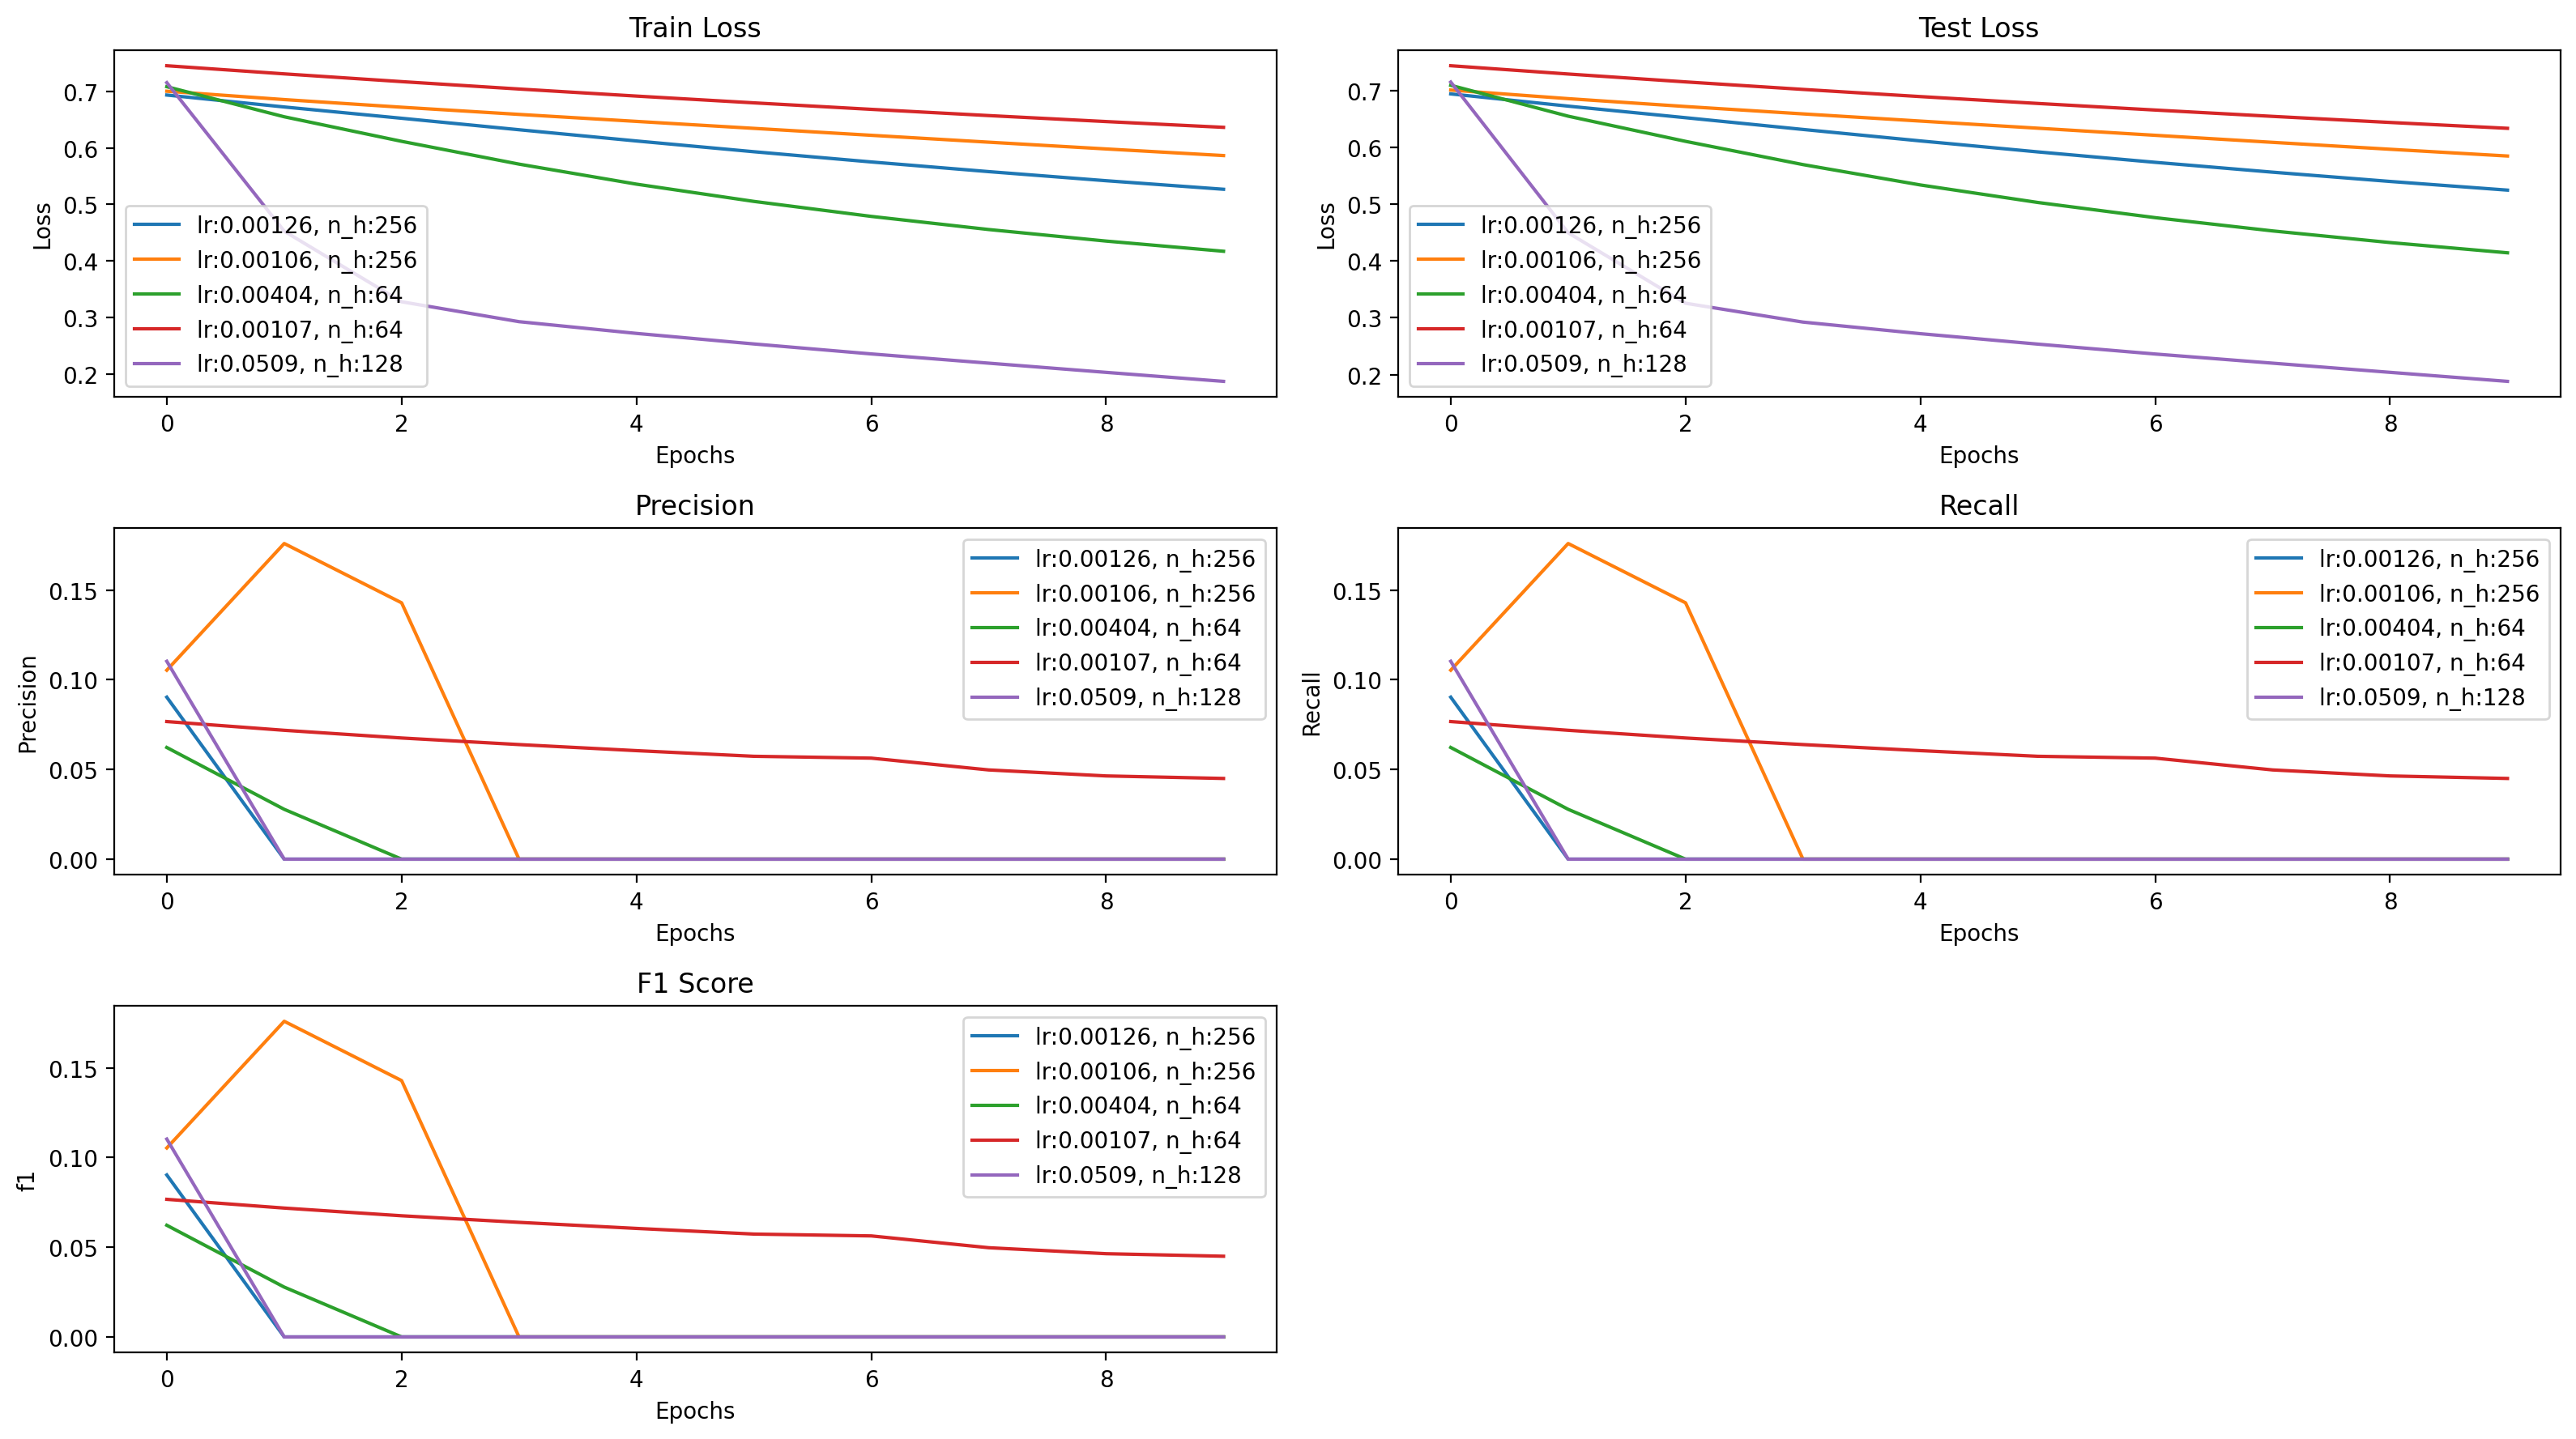

In [ ]:
plot_results(train_losses, test_losses, test_metrics, hyperparameters)

Die Bilder zeigen, dass Precision, Recall und F1 score alle auf null gehen, was bedeutet, dass nicht eine 4 richtig erkannt wurde. Dass, obwohl sich der trainingsloss zumindest teilweise verbessert hat. Wir werfen noch einmal einen Blick auf den Output des Models, um zu verstehen, was vor sich geht.

In [ ]:
num_hyperparams = 1
num_epochs = 5

_ = train_and_evaluate(num_hyperparams, 
                       num_epochs, 
                       train_data, 
                       test_data, 
                       print_prediction=True)


{'lr': 0.0714506375803825, 'n_h': 128}
prediction min,max 0.10064634446248441 0.8981803603245231
prediction min,max 2.187938932423451e-08 0.09742346634289134
prediction min,max 1.0 1.0
prediction min,max 7.124576406741285e-218 7.124576406741285e-218
prediction min,max 7.124576406741285e-218 7.124576406741285e-218


Während zu Beginn die prediction Werte zwischen 0 und 1 annimmt, wird sie nach einem Rechenschritt zur kleinst möglichen Zahl, effektiv zu 0.
Das Modell hat also gelernt, unabhängig vom Input niemals eine 4 zu erkennen.


Dieses Problem tritt auf, da diese einfache Antwort in 90 % der Fälle richtig ist, denn nur jedes zehnte Bild zeigt eine 4. Während also der Gradient von einem Bild in Richtung 1 zielt, zeigen 9 andere Bilder in Richtung 0. Dieses Ungleichgewicht zieht das Modell in die Tiefe. Da dieses Verhalten bei allen Wahlen von Hyperparametern auftritt, gibt es keine bevorzugte Wahl.

Hätten wir statt des F1 scores, Precision und Recall die normale Accuracy genommen (Anteil richtig zugeordnete Bilder), wären alle Modelle schnell bei 90% gewesen, was ein vermeintlich gutes Modell suggeriert.


Möglichkeiten, um Gleichgewicht herzustellen, sind zum Beispiel
* Minderheit Oversamplen (9 mal mehr mit vieren trainieren)
* Klassengewichtung (die beiden Klassen werden in der LossFunktion entsprechend des Ungleichgewichts gewichtet: 

 9$\times$Loss([4]) + 1$\times$Loss([0,1,2,3,5,6,7,8,9])

sowie weitere, elaboriertere Methoden.

## 5. Aufgabe: Deep Network

Nun erstellen wir ein tiefes Netzwerk mit 3 hidden Layern, um alle Ziffern korrekt zu klassifizieren.
Dieses Netwzerk soll für ein gegebenes Bild entscheiden, mit welcher Wahrscheinlichkeit es je eine der 10 Ziffern zeigt.

In [ ]:
class DeepNetwork:
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """
        Initializes a 'deep' neural network with three hidden layers
        far a specified input size, hidden size (number of nodes), and output size.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_layer1 = LinearLayer(input_size, hidden_size)
        self.hidden_layer2 = LinearLayer(hidden_size, hidden_size)
        self.hidden_layer3 = LinearLayer(hidden_size, hidden_size)
        self.output_layer = LinearLayer(hidden_size, output_size)

    def __call__(self, x): # allows to call forward using model(x) instead of model.forward(x)
        return self.forward(x)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Performs a forward pass through all layers of the deep neural network."""
        x = self.hidden_layer1.forward(x)
        x = relu(x)  # not mandatory
        x = self.hidden_layer2.forward(x)
        x = relu(x)  # not mandatory
        x = self.hidden_layer3.forward(x)
        x = relu(x)  # not mandatory
        x = self.output_layer.forward(x)
        x = softmax(x)  # has to match the target. here we output the probability for every class
        return x

    def backward(self, d_outputs: np.ndarray) -> None:
        """Performs a backward pass through all layors of the deep neural network."""
        d_hidden_outputs3 = self.output_layer.backward(d_outputs)
        d_hidden_outputs_relu3 = np.where(self.hidden_layer3.outputs > 0, d_hidden_outputs3, 0)
        d_hidden_outputs2 = self.hidden_layer3.backward(d_hidden_outputs_relu3)
        d_hidden_outputs_relu2 = np.where(self.hidden_layer2.outputs > 0, d_hidden_outputs2, 0)
        d_hidden_outputs1 = self.hidden_layer2.backward(d_hidden_outputs_relu2)
        d_hidden_outputs_relu1 = np.where(self.hidden_layer1.outputs > 0, d_hidden_outputs1, 0)
        self.hidden_layer1.backward(d_hidden_outputs_relu1)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Performs a forward pass through all layers of the deep neural network."""
        x = self.hidden_layer1.forward(x)
        x = self.hidden_layer2.forward(x)
        x = self.hidden_layer3.forward(x)
        x = self.output_layer.forward(x)
        x = softmax(x)  # has to match the target. here we output the probability for every class
        return x

    def backward(self, d_outputs: np.ndarray) -> None:
        """Performs a backward pass through all layers of the deep neural network."""
        d_hidden_outputs3 = self.output_layer.backward(d_outputs)
        d_hidden_outputs2 = self.hidden_layer3.backward(d_hidden_outputs3)
        d_hidden_outputs1 = self.hidden_layer2.backward(d_hidden_outputs2)
        self.hidden_layer1.backward(d_hidden_outputs1)


    def update(self, learning_rate: float) -> None:
        """Updates all weights and biases with gradients computed with backward."""
        self.hidden_layer1.update(learning_rate)
        self.hidden_layer2.update(learning_rate)
        self.hidden_layer3.update(learning_rate)
        self.output_layer.update(learning_rate)





def softmax(x: np.ndarray) -> np.ndarray:
    """ Computes softmax on first axis of x. output in [0,1], sum = 1 along axis 0 """
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # Subtract the maximum value for numerical stability
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)


Dieser Dummy test ist nützlich, um den Code zu debuggen. Der loss sollte monoton fallen und out sich an target anpassen.

In [ ]:

input_size = 1
output_size = 2
hidden_size = 64
lr = 0.1
N = 2


target = np.array([[0,1],[1,0]]).reshape(output_size,N)
#inp = np.random.randn(input_size, N)
inp = np.array([[0,1]])


print(target.shape, target)



network = DeepNetwork(input_size, hidden_size, output_size)

for i in range(5):
    out = network(inp)
    loss = np.mean((out - target)**2)
    print("out",list(o for o in out), "loss", loss)
    d_loss = 2*(out - target) / N

    network.backward(d_loss)
    network.update(lr)

(2, 2) [[0 1]
 [1 0]]
out [array([0.5       , 0.50485127]), array([0.5       , 0.49514873])] loss 0.2475861317427683
out [array([0.4996164 , 0.52179069]), array([0.5003836 , 0.47820931])] loss 0.23915034550566386
out [array([0.49791166, 0.53947574]), array([0.50208834, 0.46052426])] loss 0.22999930449784414
out [array([0.49487984, 0.56111205]), array([0.50512016, 0.43888795])] loss 0.2187643456693877
out [array([0.49020067, 0.58963536]), array([0.50979933, 0.41036464])] loss 0.20434791919864745


Für die Klassifikation der MNIST Bilder eignet sich der Cross-Entropy-Loss, welcher die Wahrscheinlichkeitsverteilung der Klassen direkt optimiert.

\begin{equation}
CELoss = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \log(p_{i,j})
\end{equation}

Hierbei bezeichnet $N$ die Anzahl der Beispiele im Datensatz, $C$ die Anzahl der Klassen, $y_{i,j}$ ist ein Indikator, ob das $i$-te Beispiel zur Klasse $j$ gehört (1, wenn ja, 0 sonst), und $p_{i,j}$ ist die vorhergesagte Wahrscheinlichkeit des Modells, dass das $i$-te Beispiel zur Klasse $j$ gehört.

Der Cross-Entropy-Loss berechnet für die korrekten Klassen ($y_{i,j}=1$) den negativen Logarithmus der entsprechend zugeordneten Wahrscheinlichkeit.
Der Loss wird null, wenn all diese Wahrscheinlichkeiten =1 sind und wird grösser, je kleiner diese werden. Da die Summe der Wahrscheinlichkeiten für ein Bild 1 ist, werden durch das erhöhen richtiger Klassen gleichzeitig falsche Klassen vermindert.


Für die MNIST-Klassifikation ist der Cross-Entropy-Loss (CELoss) eine bessere Wahl als der Mean Squared Error (MSE), da das Ziel darin besteht, eine Wahrscheinlichkeitsverteilung über alle Klassen zu erhalten. Der CELoss optimiert direkt die Wahrscheinlichkeitsverteilung, während der MSE die Differenz zwischen der tatsächlichen und der vorhergesagten Zahl direkt minimiert. Da die Klassen öfter Falsch als richtig sind, neigt MSE dazu, alle Wahrscheinlichkeiten zu vermindern. Daher hat MSE Schwierigkeiten, mit den vielen Klassen umzugehen und es würde viel länger dauern, bis das Modell konvergiert.



In [ ]:
import numpy as np

class CrossEntropyLoss:
    def __init__(self):
        self.softmax_output = None
        self.targets = None
    
    def __call__(self, predictions, targets):
        return self.forward(predictions, targets)
    
    def forward(self, predictions: np.ndarray, targets: np.ndarray, eps=1e-8) -> float:
        """Calculates the cross-entropy loss.
        Assumes prediction is one-hot-encoded, while targets are integers showing the correct class"""
        self.targets = targets
        self.predictions = predictions
        N = predictions.shape[1]
        loss = -np.log(predictions[targets, range(N)] + eps) # add small number to omit log(0)
        loss = np.mean(loss)
        return loss

    def derivative(self) -> np.ndarray:
        """Calculates the derivative of the cross-entropy loss."""
        d_softmax = self.predictions
        N = d_softmax.shape[1]
        d_softmax[self.targets, range(N)] -= 1
        d_softmax /= N
        return d_softmax


Die Daten werden dem Task entsprechend vorbereitet.
Diesmal verwenden wir die unveränderten labels.

In [ ]:
def preprocess_data(data) -> tuple:
    """Preprocesses the input data for a neural network model.

    The preprocessing steps include converting the data to a numpy array, 
    reshaping the images to the appropriate shape for a linear layer, 
    normalizing the pixel values to be between 0 and 1, 
    and transposing the image array to fit the assumed shape = (N_pixels, N_batch).
    """
    images = np.array([np.array(x) for x in data.data])
    images = images.reshape(images.shape[0], -1)
    images = images / 255.0
    images = images.T  ## LinearLayer assumes input shape = (input_size, N_batch)
    labels = np.array(data.targets)
    return images, labels

Da die Verteilung der Klassen gut balanciert ist (sprich, jede Ziffer kommt etwa gleich oft vor), eignet sich für dieses Problem der Accuracy Score, der den Anteil richtiger Klassifizierungen misst
\begin{equation}
Accuracy = \frac{\text{True Positive} + \text{True Negative}}{\text{Alle}}
=  \frac{1}{N} \sum_{i=1}^N (y_i = \hat{y_i})
\end{equation}

Die Accuracy ist eine einfache und intuitive Metrik, die den Prozentsatz der korrekt klassifizierten Beispiele im Verhältnis zur Gesamtzahl der Beispiele angibt. Wenn die Klassen ausgeglichen sind, ist die Accuracy ein zuverlässiger Indikator für die Gesamtleistung des Klassifikators.

F1, Precision und Recall sind hingegen spezifischere Metriken, die insbesondere in Situationen nützlich sind, in denen die Kosten für falsch positive und falsch negative Vorhersagen unterschiedlich sind. Diese Metriken können jedoch in Situationen mit ausgeglichenen Klassen ungleichmäßige Ergebnisse liefern, da sie sich auf bestimmte Klassen konzentrieren und nicht die Gesamtleistung des Klassifikators widerspiegeln.

Um bei mehreren Klassen herauszufinden, welche Vorhersagen ein Klassifikator korrekt macht und welche nicht, ist die Verwendung einer Confusion Matrix eine nützliche Methode. Die Confusion Matrix ist eine Tabelle, wie True/False Positive/Negative, die zeigt, wie oft jede Klasse korrekt oder inkorrekt vorhergesagt wurde und mit welcher Klasse sie oft verwechselt wird.


In [ ]:
def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the accuracy score (amount of correctly classified images)"""
    # Compute the ratio of correctly predicted labels
    return np.mean(y_true == y_pred)
    

def plot_confusion_matrix(predictions: np.ndarray, labels: np.ndarray, class_names: list = list(range(10))) -> None:
    """
    Plot a confusion matrix using the given one-hot encoded predictions and target labels.
    """
    # Get the number of classes
    num_classes = len(class_names)

    # Initialize the confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=int)

    # Fill the confusion matrix
    predicted_label = np.argmax(predictions, axis=0)
    for t, p in zip(labels, predicted_label):
        cm[t][p] += 1

    # If class names are not provided, use default names
    if class_names is None:
        class_names = ['Class {}'.format(i) for i in range(num_classes)]

    # Plot confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()



Der Trainingsvorgang bleibt grundsätzlich der selbe, nur dass Modell, label und loss_function entsprechend angepasst wurden.
Wieder machen wir mehrere runs mit zufälligen Parametern und wählen das Modell mit der besten performance.

In [ ]:
def train_network(num_trainings: int=5, epochs: int=5, train_data=None, test_data=None, print_predictions=False) -> tuple:
    """
    Trains a deep neural network using stochastic gradient descent with cross-entropy loss.

    Args:
    - num_trainings (int): The number of trainings to run. Default: 5.
    - epochs (int): The number of epochs to train each network. Default: 5.
    - train_data: The training data. Default: None.
    - test_data: The test data. Default: None.

    Returns:
    - tuple: A tuple containing the labels, train losses, test losses, and test accuracies for each training run.
    """


    output_size = 10 # Anzahl Klassen

    # Daten vorbereiten
    train_images, train_labels = preprocess_data(train_data)
    test_images, test_labels = preprocess_data(test_data)


    all_labels = []
    all_train_losses = []
    all_test_losses = []
    all_test_accuracies = []
    for i in range(num_trainings):
        # Hyperparameters
        hidden_size = np.random.choice([64,128,256])
        learning_rate = 10.**np.random.uniform(-2, 0)
        label = f"lr={learning_rate:.2g}, n_h={hidden_size}"
        print(label)

        # setup model and loss function
        input_size = train_images.shape[0]
        network = DeepNetwork(input_size, hidden_size, output_size)
        loss_function = CrossEntropyLoss()

        # Trainings-Loop
        train_losses = []
        test_losses = []
        test_accuracies = []

        for epoch in range(epochs):

            # compute test loss   do that before training, such that results for an epoch refer to the same state of the model
            test_predictions = network.forward(test_images)
            test_loss = loss_function(test_predictions, test_labels)
            test_losses.append(test_loss)
            if epoch == epochs-1:
                plot_confusion_matrix(test_predictions, test_labels)
            if print_predictions:
                print("prediction", test_predictions[:,:2])
            test_predictions = np.argmax(test_predictions, axis=0)  # convert one-hot-encoded predictions to class labels
            test_accuracy = accuracy_score(test_labels, test_predictions)
            test_accuracies.append(test_accuracy)


            # Forward-Pass
            predictions = network.forward(train_images)

            # compute train loss
            loss = loss_function(predictions, train_labels)
            train_losses.append(loss)

            # Backward-Pass
            d_outputs = loss_function.derivative()
            network.backward(d_outputs)

            # update parameters (weights and biases)
            network.update(learning_rate)

            print(f'Training {i+1}/{num_trainings}, Epoch {epoch + 1}/{epochs}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


        all_labels.append(label)
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
        all_test_accuracies.append(test_accuracies)
    return all_labels, all_train_losses, all_test_losses, all_test_accuracies

def plot_results(labels: list[str], train_losses: list[list[float]], test_losses: list[list[float]], test_accuracies: list[list[float]]):
    """
    Plots the train and test losses and accuracy scores for multiple training runs.
    """
    # Plot train and test losses and accuracy scores for all runs
    plt.figure(figsize=(10, 4))

    # Plot train losses
    plt.subplot(1, 2, 1)
    for label, train_loss in zip(labels, train_losses):
        plt.plot(train_loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()

    # Plot test losses
    plt.subplot(1, 2, 2)
    for label, test_loss in zip(labels, test_losses):
        plt.plot(test_loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot test accuracies
    plt.figure(figsize=(5, 4))
    for label, test_accuracy in zip(labels, test_accuracies):
        plt.plot(test_accuracy, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


lr=0.024, n_h=256
Training 1/5, Epoch 1/5, Train Loss: 2.3026, Test Loss: 2.3026, Test Accuracy: 0.0504
Training 1/5, Epoch 2/5, Train Loss: 2.3026, Test Loss: 2.3026, Test Accuracy: 0.0659
Training 1/5, Epoch 3/5, Train Loss: 2.3026, Test Loss: 2.3026, Test Accuracy: 0.0987
Training 1/5, Epoch 4/5, Train Loss: 2.3026, Test Loss: 2.3026, Test Accuracy: 0.1104


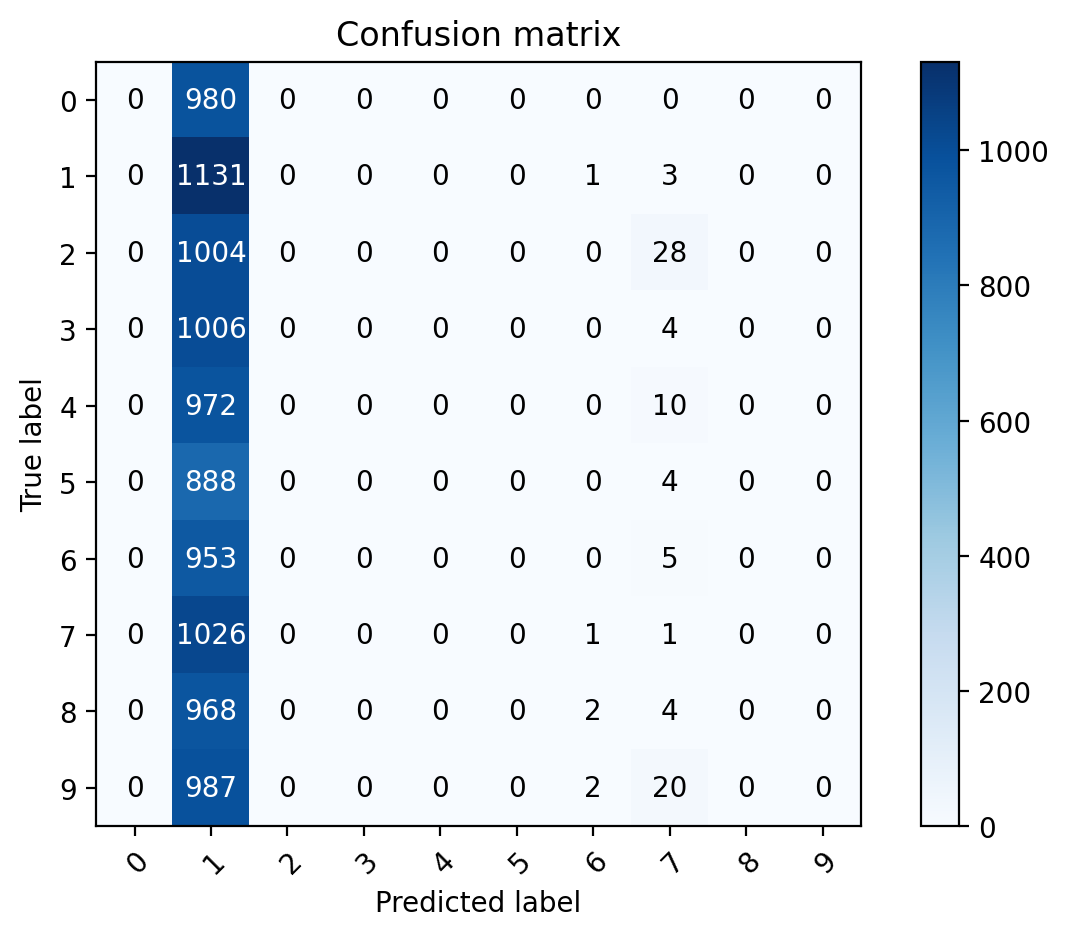

Training 1/5, Epoch 5/5, Train Loss: 2.3026, Test Loss: 2.3026, Test Accuracy: 0.1132
lr=0.14, n_h=256
Training 2/5, Epoch 1/5, Train Loss: 2.3025, Test Loss: 2.3025, Test Accuracy: 0.1260
Training 2/5, Epoch 2/5, Train Loss: 2.3024, Test Loss: 2.3024, Test Accuracy: 0.1361
Training 2/5, Epoch 3/5, Train Loss: 2.3023, Test Loss: 2.3022, Test Accuracy: 0.1135
Training 2/5, Epoch 4/5, Train Loss: 2.3021, Test Loss: 2.3021, Test Accuracy: 0.1135


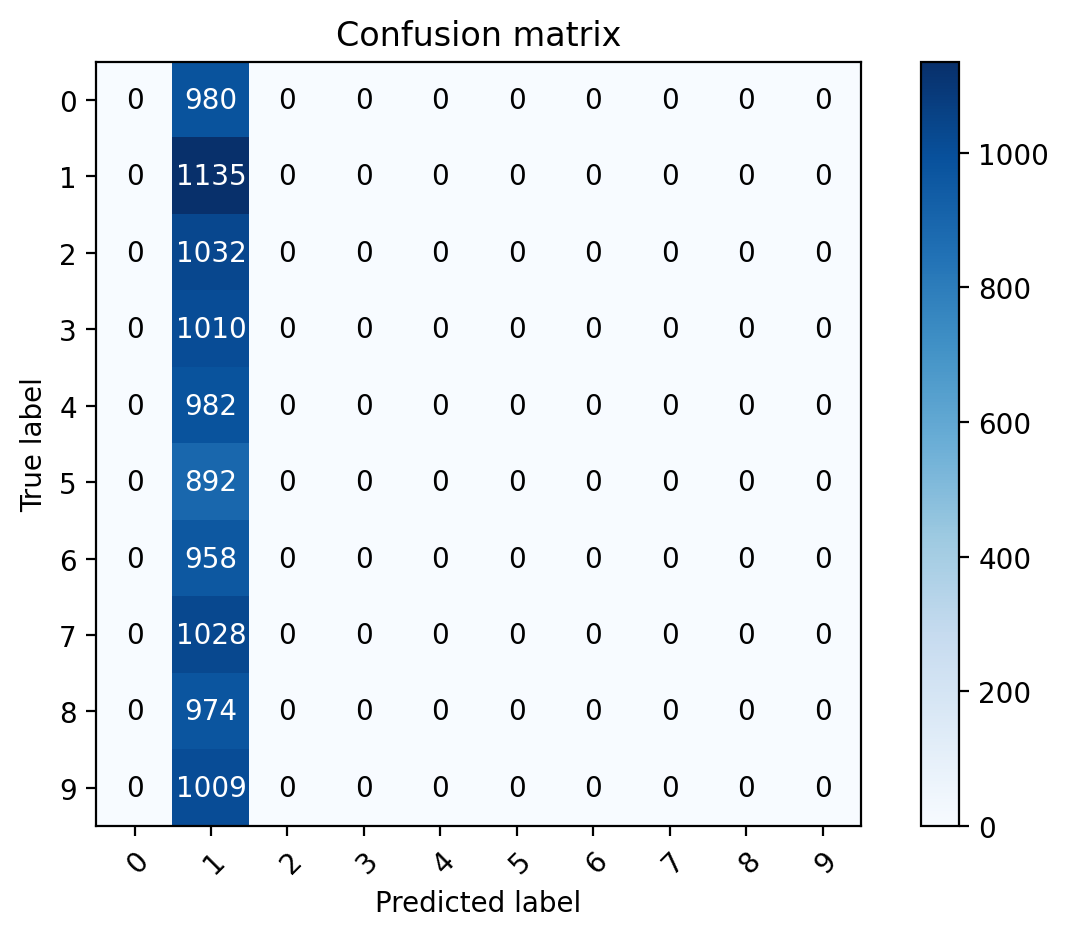

Training 2/5, Epoch 5/5, Train Loss: 2.3020, Test Loss: 2.3020, Test Accuracy: 0.1135
lr=0.21, n_h=256
Training 3/5, Epoch 1/5, Train Loss: 2.3020, Test Loss: 2.3020, Test Accuracy: 0.1169
Training 3/5, Epoch 2/5, Train Loss: 2.2954, Test Loss: 2.2952, Test Accuracy: 0.4456
Training 3/5, Epoch 3/5, Train Loss: 2.2886, Test Loss: 2.2883, Test Accuracy: 0.5963
Training 3/5, Epoch 4/5, Train Loss: 2.2815, Test Loss: 2.2811, Test Accuracy: 0.6451


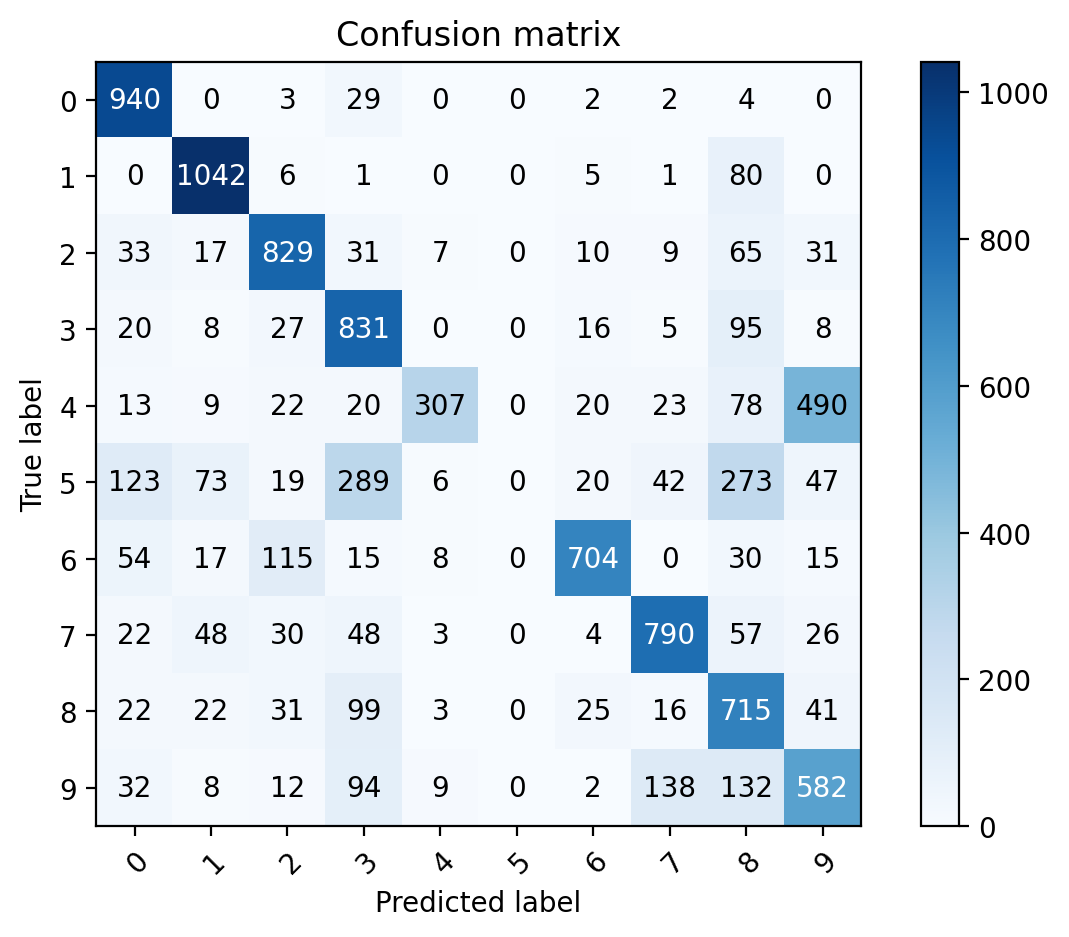

Training 3/5, Epoch 5/5, Train Loss: 2.2738, Test Loss: 2.2733, Test Accuracy: 0.6740
lr=0.014, n_h=128
Training 4/5, Epoch 1/5, Train Loss: 2.3023, Test Loss: 2.3023, Test Accuracy: 0.1176
Training 4/5, Epoch 2/5, Train Loss: 2.3022, Test Loss: 2.3021, Test Accuracy: 0.1205
Training 4/5, Epoch 3/5, Train Loss: 2.3020, Test Loss: 2.3020, Test Accuracy: 0.1233
Training 4/5, Epoch 4/5, Train Loss: 2.3019, Test Loss: 2.3018, Test Accuracy: 0.1259


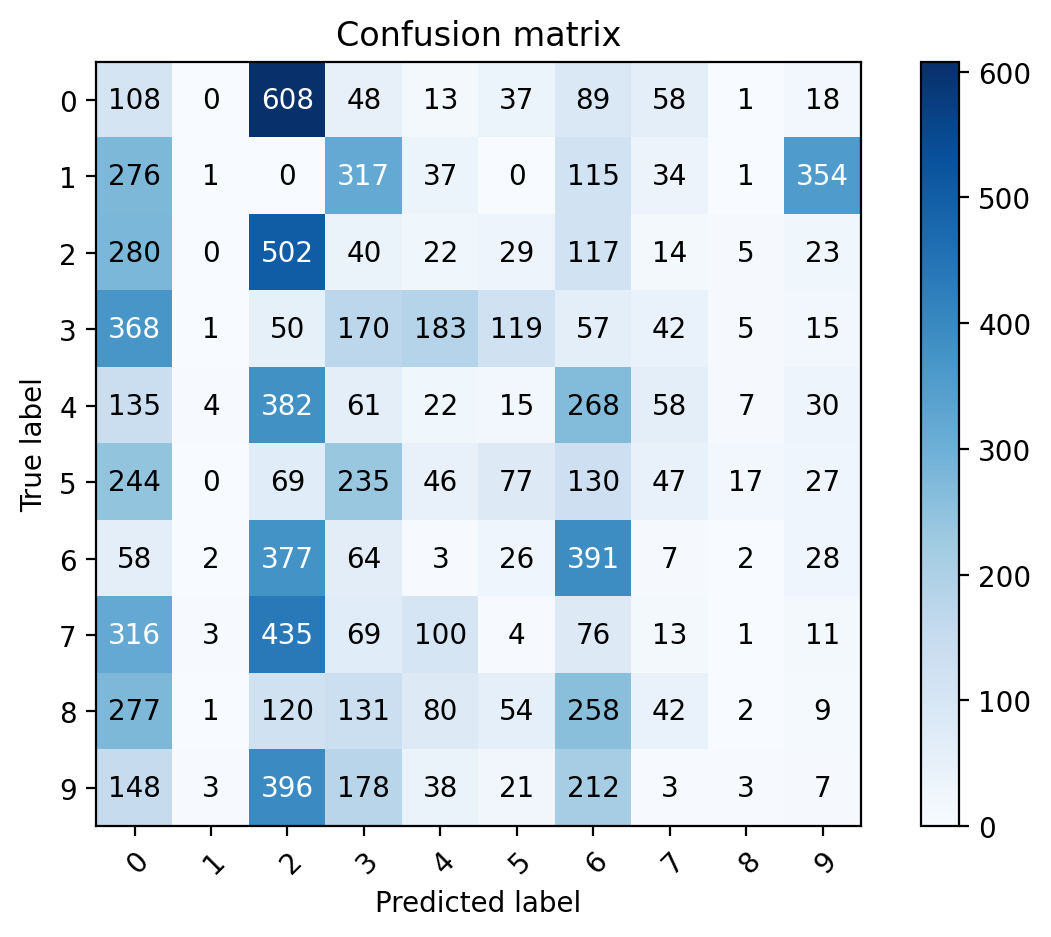

Training 4/5, Epoch 5/5, Train Loss: 2.3018, Test Loss: 2.3017, Test Accuracy: 0.1293
lr=0.35, n_h=64
Training 5/5, Epoch 1/5, Train Loss: 2.3026, Test Loss: 2.3026, Test Accuracy: 0.1130
Training 5/5, Epoch 2/5, Train Loss: 2.3022, Test Loss: 2.3022, Test Accuracy: 0.1135
Training 5/5, Epoch 3/5, Train Loss: 2.3019, Test Loss: 2.3019, Test Accuracy: 0.1135
Training 5/5, Epoch 4/5, Train Loss: 2.3016, Test Loss: 2.3016, Test Accuracy: 0.1135


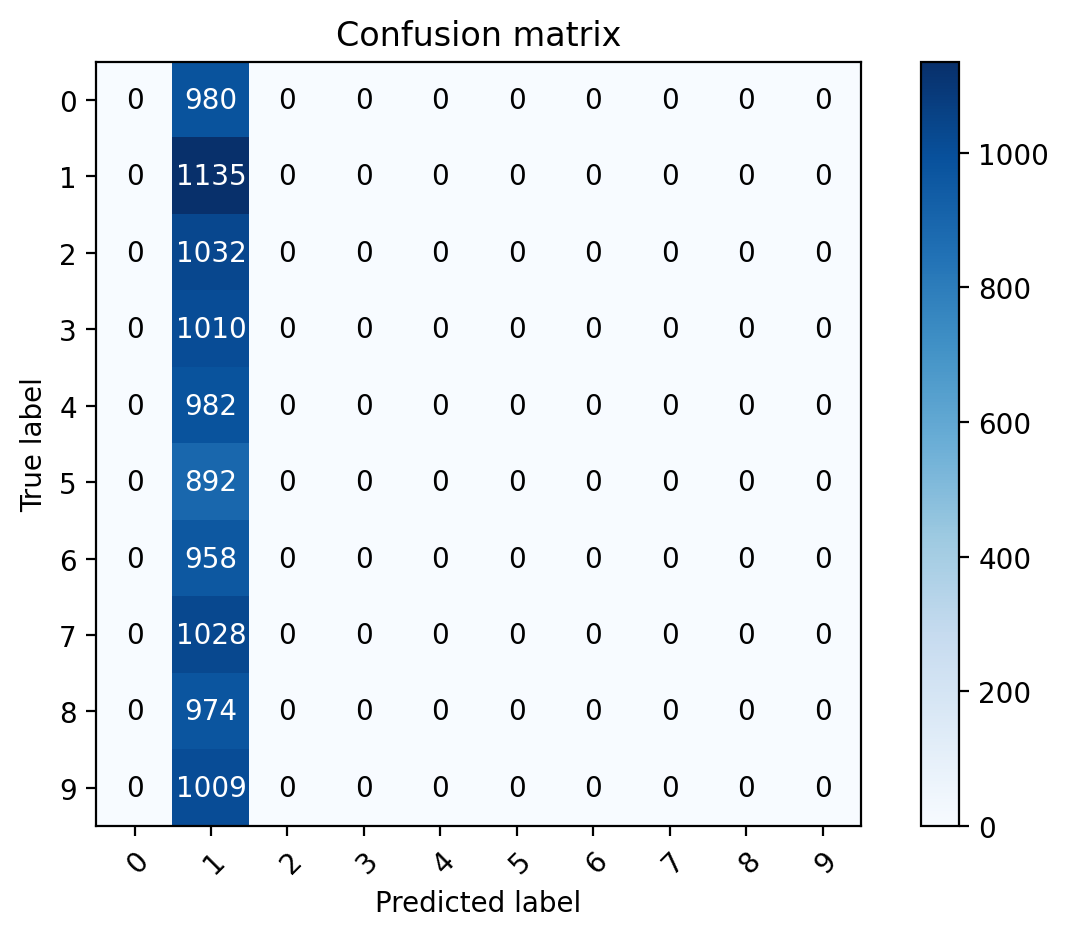

Training 5/5, Epoch 5/5, Train Loss: 2.3013, Test Loss: 2.3012, Test Accuracy: 0.1135


In [ ]:
num_trainings=5
epochs=5
labels, train_losses, test_losses, test_accuracies = \
    train_network(num_trainings=num_trainings, epochs=epochs, train_data=train_data, test_data=test_data)

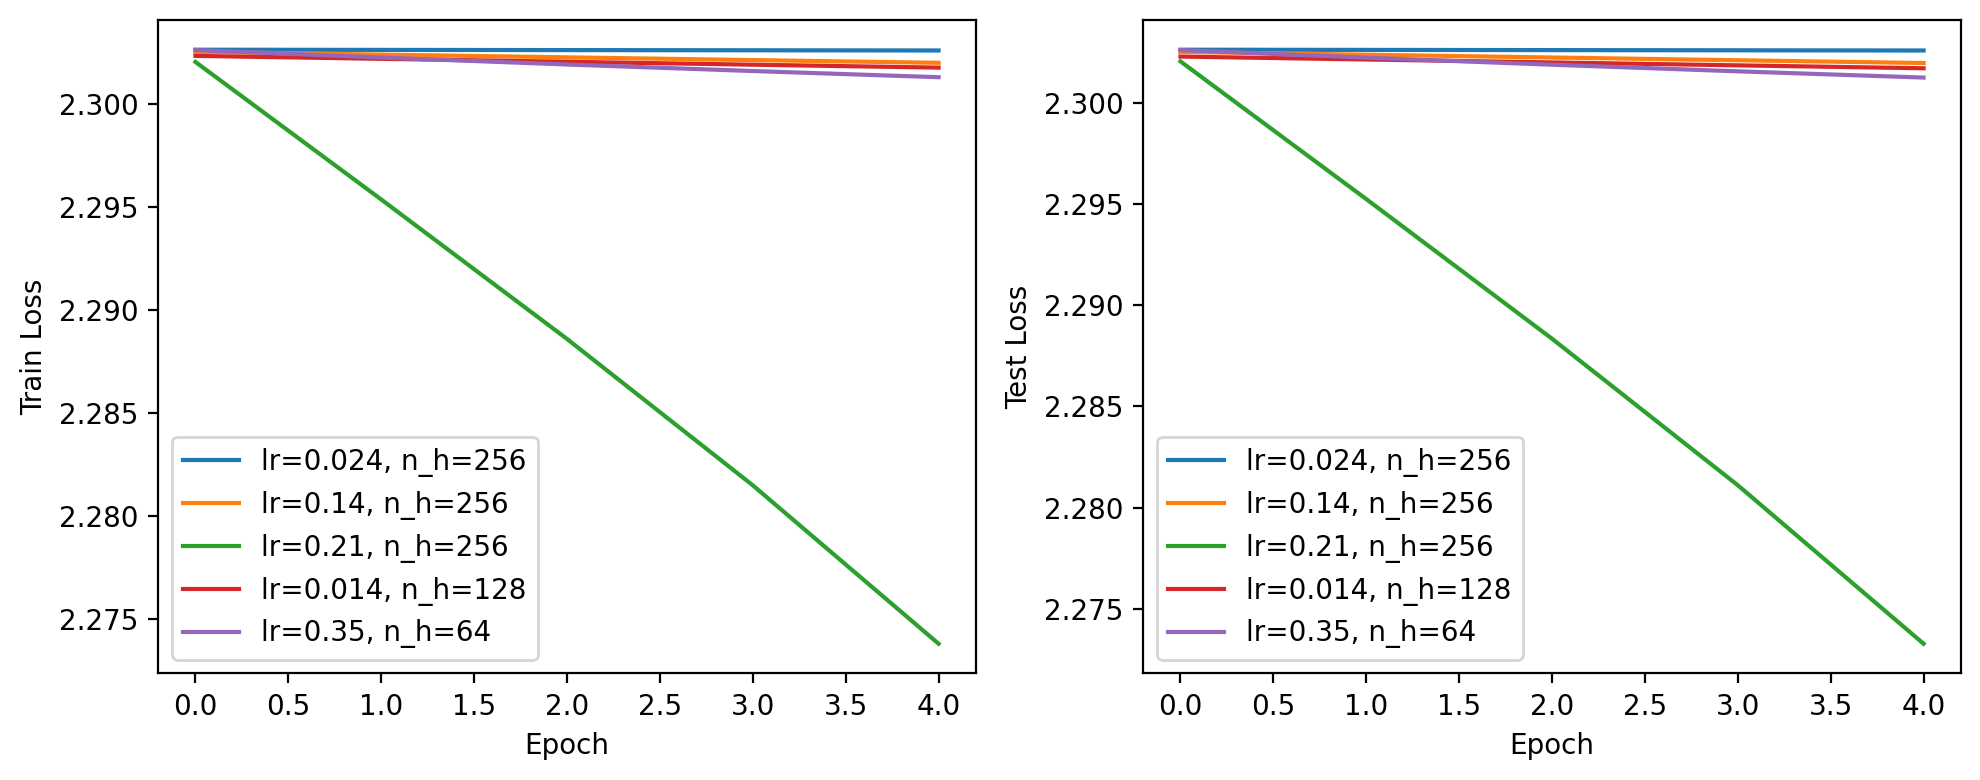

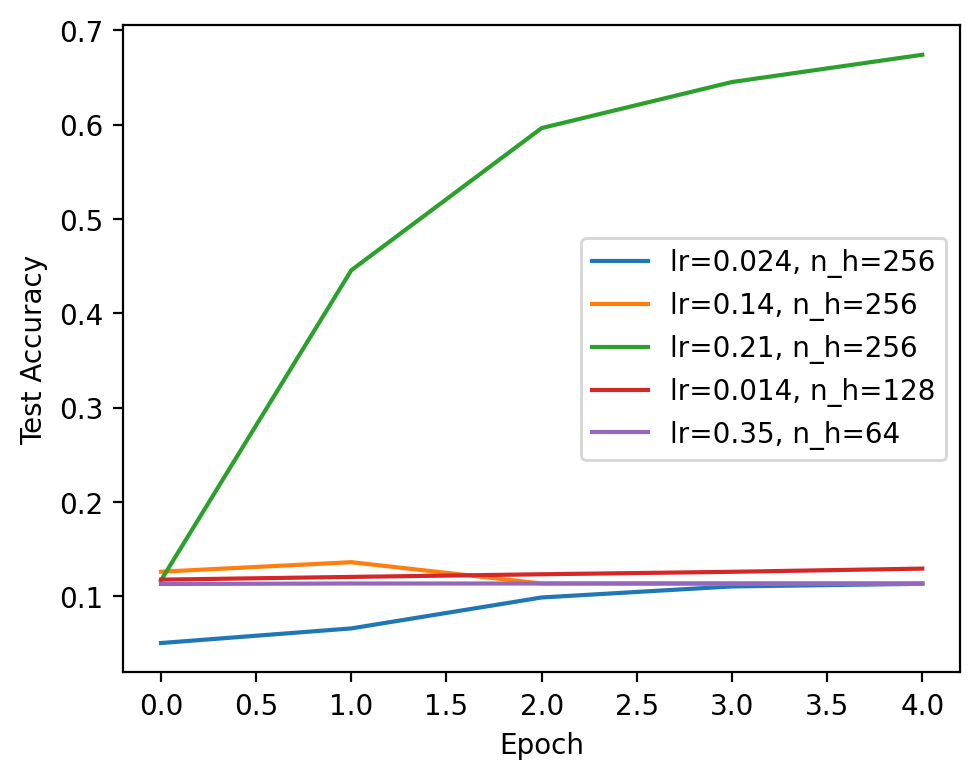

In [ ]:
plot_results(labels, train_losses, test_losses, test_accuracies)

Scheinbar unabhängig von learning rate und Grösse der hidden layer bleiben die meisten der Modelle bei einer accuracy um 10 %. Bei 10 Klassen so gut wie Raten oder ständig die gleiche Antwort zu geben. Ein Blick auf die Confusion Matritzen der einzelnen runs zeigt, dass die Modelle tatsächlich sehr häufig die gleiche Antwort geben, auch wenn sie sich nicht immer auf die selbe Antwort einschiessen.

Um das genauer zu verstehen, betrachten wir den output des Modells.

lr=0.45, n_h=128
prediction [[0.10037341 0.10015165]
 [0.10104432 0.09829304]
 [0.0991684  0.09918652]
 [0.09987563 0.10184011]
 [0.09952949 0.09935404]
 [0.09946924 0.10045902]
 [0.10261251 0.10283454]
 [0.10010052 0.09871489]
 [0.09921156 0.10057264]
 [0.09861492 0.09859355]]
Training 1/1, Epoch 1/5, Train Loss: 2.3043, Test Loss: 2.3045, Test Accuracy: 0.0844
prediction [[0.10072188 0.10065133]
 [0.10060931 0.09913782]
 [0.09911448 0.10006368]
 [0.10006982 0.10303809]
 [0.09962852 0.09767088]
 [0.09872502 0.099666  ]
 [0.10131414 0.10337169]
 [0.10203544 0.09731675]
 [0.09888328 0.10132998]
 [0.09889811 0.09775378]]
Training 1/1, Epoch 2/5, Train Loss: 2.2900, Test Loss: 2.2899, Test Accuracy: 0.2801
prediction [[0.10121526 0.10113161]
 [0.10005306 0.09994232]
 [0.09892355 0.10108913]
 [0.10021392 0.1042841 ]
 [0.09973868 0.09588365]
 [0.09806264 0.09892012]
 [0.10004567 0.10405975]
 [0.10413548 0.09568675]
 [0.09842415 0.10215426]
 [0.09918759 0.09684833]]
Training 1/1, Epoch 3/5, 

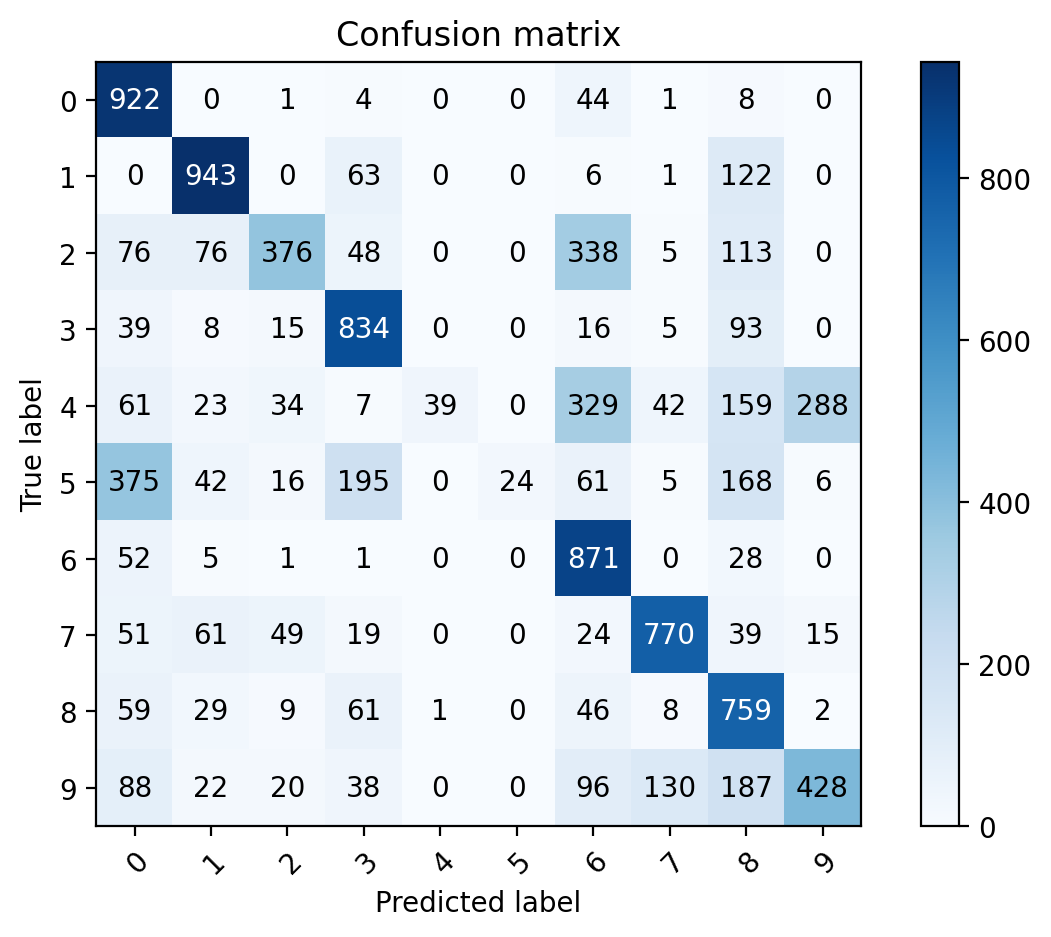

prediction [[0.10331894 0.10318632]
 [0.09704236 0.10183715]
 [0.09738007 0.10454571]
 [0.10015617 0.10778727]
 [0.10069049 0.09061762]
 [0.0972987  0.09734765]
 [0.0965872  0.10660389]
 [0.11060903 0.08981595]
 [0.09646618 0.1047034 ]
 [0.10045087 0.09355504]]
Training 1/1, Epoch 5/5, Train Loss: 2.2262, Test Loss: 2.2250, Test Accuracy: 0.5966


In [ ]:
num_trainings=1
epochs=5
labels, train_losses, test_losses, test_accuracies = \
    train_network(print_predictions=True, num_trainings=num_trainings, epochs=epochs, train_data=train_data, test_data=test_data)

Die predictions für die verschiedenen Klassen sind nahezu identisch. 
Im Training wurde auf allen Daten im selben Schritt trainiert. Der Cross Entropy Loss zieht die richtigen Vorhersagen nach obene Da in dem Datenset alle Klassen ähnlich oft vorkommen, werden alle gleich stark nach oben gezogen. Dadurch entsteht ein Gleichgewicht zwischen den predictions der verschiedenen Klassen und der Output wird unabhaengig vom Input.

Das Problem können wir beheben, indem wir nicht gleichzeitig alle Klassen nach oben ziehen, sondern mal diese, mal jene. Dies erreichen wir praktisch durch das aufteilen der Trainingsdaten in mehrere Teile (batches), auf denen das Modell dann nacheinander trainiert wird. Die batch size sollt dabei klein genug gewaehlt werden, dass nur selten alle Ziffern in gleicher Anzahl vertreten sind.

Dadurch werden die zu berechnenden Matrix multiplikationen stark vereinfacht und das training immens beschleunigt.

In [ ]:
def train_network(batch_size=32, num_trainings: int=5, epochs: int=5, train_data=None, test_data=None) -> tuple:
    """
    Trains a deep neural network using stochastic gradient descent with cross-entropy loss.

    Args:
    - num_trainings (int): The number of trainings to run. Default: 5.
    - epochs (int): The number of epochs to train each network. Default: 5.
    - train_data: The training data. Default: None.
    - test_data: The test data. Default: None.

    Returns:
    - tuple: A tuple containing the labels, train losses, test losses, and test accuracies for each training run.
    """


    output_size = 10 # Anzahl Klassen

    # Daten vorbereiten
    train_images, train_labels = preprocess_data(train_data)
    test_images, test_labels = preprocess_data(test_data)


    all_labels = []
    all_train_losses = []
    all_test_losses = []
    all_test_accuracies = []
    for i in range(num_trainings):
        # Hyperparameters
        hidden_size = np.random.choice([64,128,256])
        learning_rate = 10.**np.random.uniform(-2, 0)
        label = f"lr={learning_rate:.2g}, n_h={hidden_size}"
        print(label)

        # setup model and loss function
        input_size = train_images.shape[0]
        network = DeepNetwork(input_size, hidden_size, output_size)
        loss_function = CrossEntropyLoss()

        # Trainings-Loop
        train_losses = []
        test_losses = []
        test_accuracies = []

        for epoch in range(epochs):

            # compute test loss   do that before training, such that results for an epoch refer to the same state of the model
            test_predictions = network.forward(test_images)
            test_loss = loss_function(test_predictions, test_labels)
            test_losses.append(test_loss)
            if epoch == epochs-1:
                plot_confusion_matrix(test_predictions, test_labels)
            test_predictions = np.argmax(test_predictions, axis=0)  # convert one-hot-encoded predictions to class labels
            test_accuracy = accuracy_score(test_labels, test_predictions)
            test_accuracies.append(test_accuracy)

            train_loss = 0.
            for b in range(train_images.shape[0]//batch_size):
                # Forward-Pass
                predictions = network.forward(train_images[:,b*batch_size:(b+1)*batch_size])

                # compute train loss
                loss = loss_function(predictions, train_labels[b*batch_size:(b+1)*batch_size])
                train_loss += loss

                # Backward-Pass
                d_outputs = loss_function.derivative()
                network.backward(d_outputs)

                # update parameters (weights and biases)
                network.update(learning_rate)
            train_losses.append(train_loss)

            print(f'Training {i+1}/{num_trainings}, Epoch {epoch + 1}/{epochs}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


        all_labels.append(label)
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
        all_test_accuracies.append(test_accuracies)
    return all_labels, all_train_losses, all_test_losses, all_test_accuracies

lr=0.11, n_h=256
Training 1/5, Epoch 1/20, Train Loss: 2.3084, Test Loss: 2.3024, Test Accuracy: 0.1126
Training 1/5, Epoch 2/20, Train Loss: 2.3069, Test Loss: 2.2975, Test Accuracy: 0.1135
Training 1/5, Epoch 3/20, Train Loss: 2.2975, Test Loss: 2.2913, Test Accuracy: 0.1135
Training 1/5, Epoch 4/20, Train Loss: 2.2572, Test Loss: 2.2779, Test Accuracy: 0.1262
Training 1/5, Epoch 5/20, Train Loss: 2.0350, Test Loss: 2.2292, Test Accuracy: 0.3194
Training 1/5, Epoch 6/20, Train Loss: 1.6237, Test Loss: 1.9460, Test Accuracy: 0.2888
Training 1/5, Epoch 7/20, Train Loss: 1.0813, Test Loss: 1.5385, Test Accuracy: 0.5111
Training 1/5, Epoch 8/20, Train Loss: 0.8229, Test Loss: 1.0597, Test Accuracy: 0.6400
Training 1/5, Epoch 9/20, Train Loss: 0.6659, Test Loss: 0.9514, Test Accuracy: 0.6730
Training 1/5, Epoch 10/20, Train Loss: 0.5441, Test Loss: 0.9038, Test Accuracy: 0.6969
Training 1/5, Epoch 11/20, Train Loss: 0.4541, Test Loss: 0.8361, Test Accuracy: 0.7293
Training 1/5, Epoch 12/2

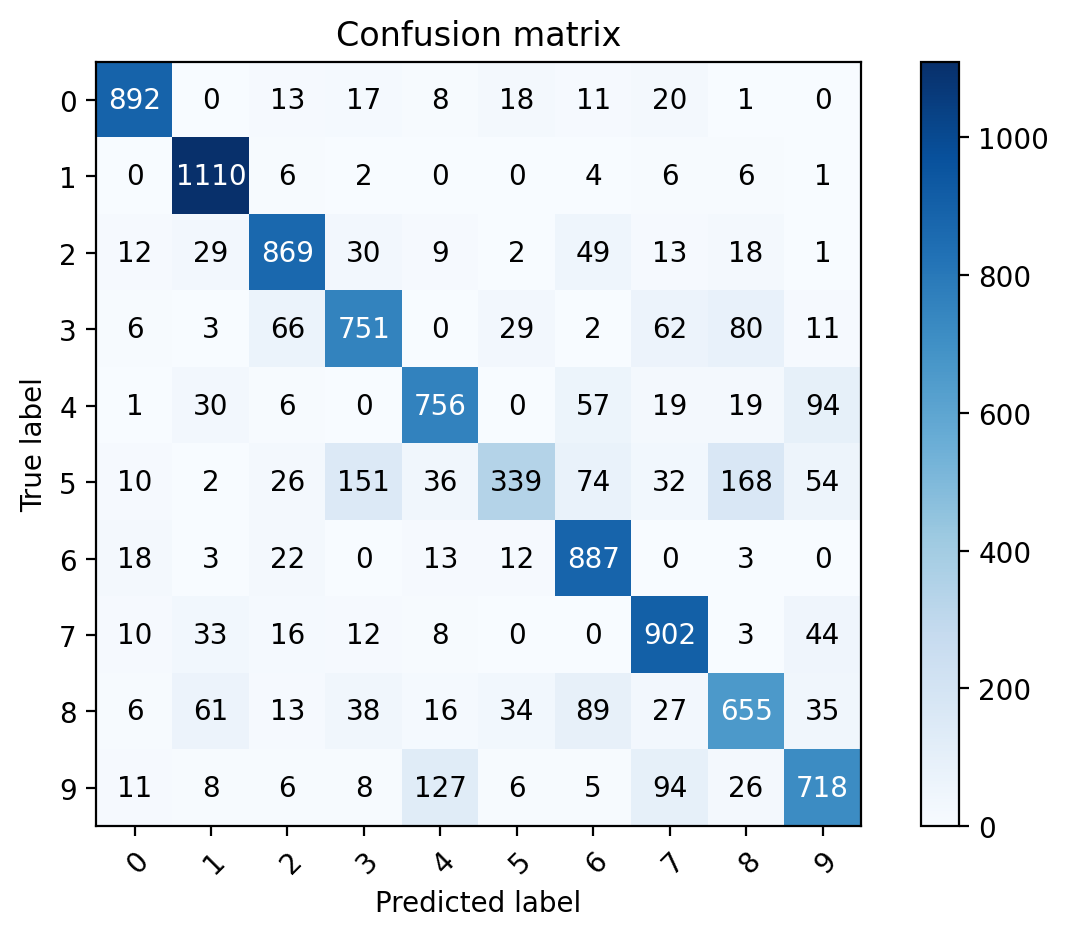

Training 1/5, Epoch 20/20, Train Loss: 0.2183, Test Loss: 0.8952, Test Accuracy: 0.7879
lr=0.011, n_h=256
Training 2/5, Epoch 1/20, Train Loss: 2.3056, Test Loss: 2.3026, Test Accuracy: 0.0440
Training 2/5, Epoch 2/20, Train Loss: 2.3073, Test Loss: 2.3020, Test Accuracy: 0.1135
Training 2/5, Epoch 3/20, Train Loss: 2.3088, Test Loss: 2.3016, Test Accuracy: 0.1135
Training 2/5, Epoch 4/20, Train Loss: 2.3103, Test Loss: 2.3013, Test Accuracy: 0.1135
Training 2/5, Epoch 5/20, Train Loss: 2.3116, Test Loss: 2.3010, Test Accuracy: 0.1135
Training 2/5, Epoch 6/20, Train Loss: 2.3128, Test Loss: 2.3009, Test Accuracy: 0.1135
Training 2/5, Epoch 7/20, Train Loss: 2.3139, Test Loss: 2.3008, Test Accuracy: 0.1135
Training 2/5, Epoch 8/20, Train Loss: 2.3149, Test Loss: 2.3007, Test Accuracy: 0.1135
Training 2/5, Epoch 9/20, Train Loss: 2.3158, Test Loss: 2.3007, Test Accuracy: 0.1135
Training 2/5, Epoch 10/20, Train Loss: 2.3166, Test Loss: 2.3007, Test Accuracy: 0.1135
Training 2/5, Epoch 11/

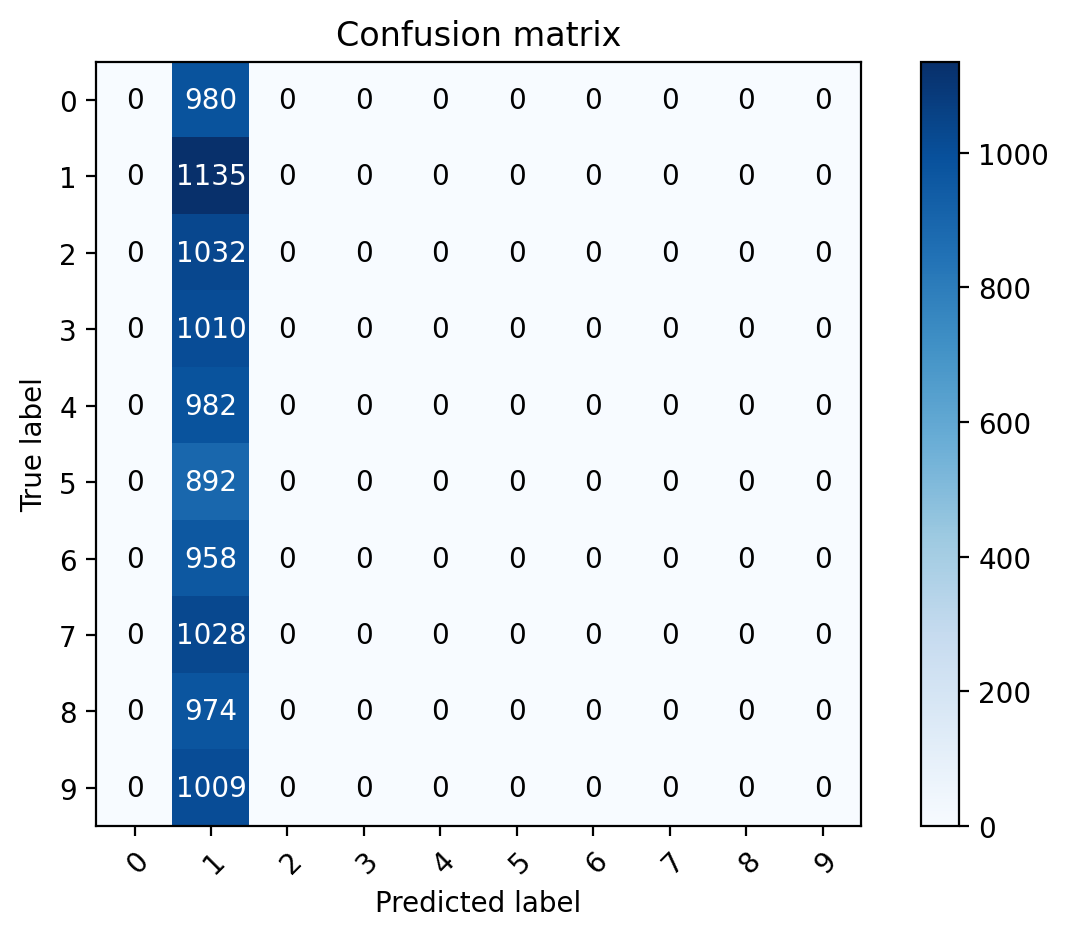

Training 2/5, Epoch 20/20, Train Loss: 2.3207, Test Loss: 2.3002, Test Accuracy: 0.1135
lr=0.7, n_h=256
Training 3/5, Epoch 1/20, Train Loss: 2.3437, Test Loss: 2.3026, Test Accuracy: 0.1041
Training 3/5, Epoch 2/20, Train Loss: 3.1919, Test Loss: 2.3006, Test Accuracy: 0.0982
Training 3/5, Epoch 3/20, Train Loss: nan, Test Loss: 5.1755, Test Accuracy: 0.0825
Training 3/5, Epoch 4/20, Train Loss: nan, Test Loss: nan, Test Accuracy: 0.0980
Training 3/5, Epoch 5/20, Train Loss: nan, Test Loss: nan, Test Accuracy: 0.0980
Training 3/5, Epoch 6/20, Train Loss: nan, Test Loss: nan, Test Accuracy: 0.0980
Training 3/5, Epoch 7/20, Train Loss: nan, Test Loss: nan, Test Accuracy: 0.0980
Training 3/5, Epoch 8/20, Train Loss: nan, Test Loss: nan, Test Accuracy: 0.0980
Training 3/5, Epoch 9/20, Train Loss: nan, Test Loss: nan, Test Accuracy: 0.0980
Training 3/5, Epoch 10/20, Train Loss: nan, Test Loss: nan, Test Accuracy: 0.0980
Training 3/5, Epoch 11/20, Train Loss: nan, Test Loss: nan, Test Accur

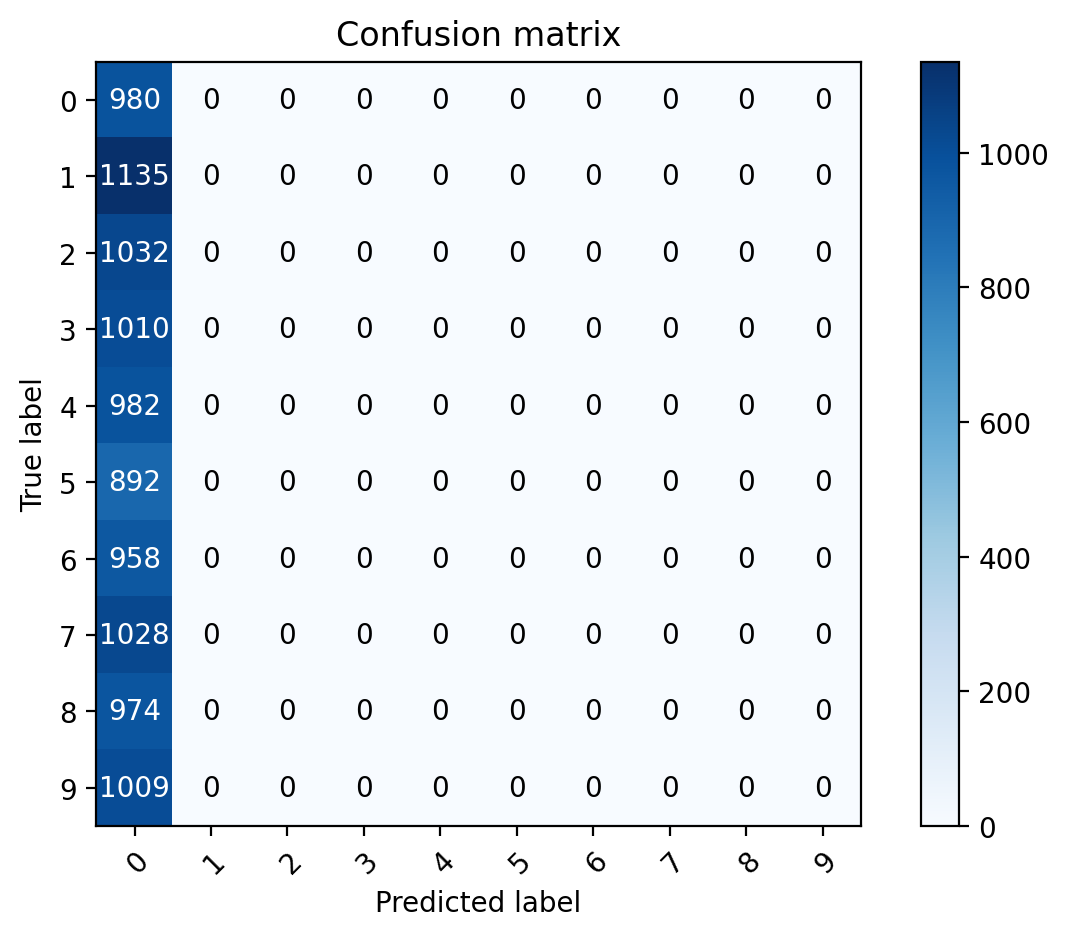

Training 3/5, Epoch 20/20, Train Loss: nan, Test Loss: nan, Test Accuracy: 0.0980
lr=0.013, n_h=64
Training 4/5, Epoch 1/20, Train Loss: 2.2964, Test Loss: 2.3033, Test Accuracy: 0.0678
Training 4/5, Epoch 2/20, Train Loss: 2.2860, Test Loss: 2.2943, Test Accuracy: 0.2081
Training 4/5, Epoch 3/20, Train Loss: 2.2714, Test Loss: 2.2838, Test Accuracy: 0.2793
Training 4/5, Epoch 4/20, Train Loss: 2.2491, Test Loss: 2.2695, Test Accuracy: 0.3278
Training 4/5, Epoch 5/20, Train Loss: 2.2143, Test Loss: 2.2483, Test Accuracy: 0.3538
Training 4/5, Epoch 6/20, Train Loss: 2.1608, Test Loss: 2.2156, Test Accuracy: 0.3678
Training 4/5, Epoch 7/20, Train Loss: 2.0839, Test Loss: 2.1650, Test Accuracy: 0.3699
Training 4/5, Epoch 8/20, Train Loss: 1.9861, Test Loss: 2.0908, Test Accuracy: 0.3693
Training 4/5, Epoch 9/20, Train Loss: 1.8777, Test Loss: 1.9935, Test Accuracy: 0.3715
Training 4/5, Epoch 10/20, Train Loss: 1.7646, Test Loss: 1.8837, Test Accuracy: 0.3825
Training 4/5, Epoch 11/20, Tra

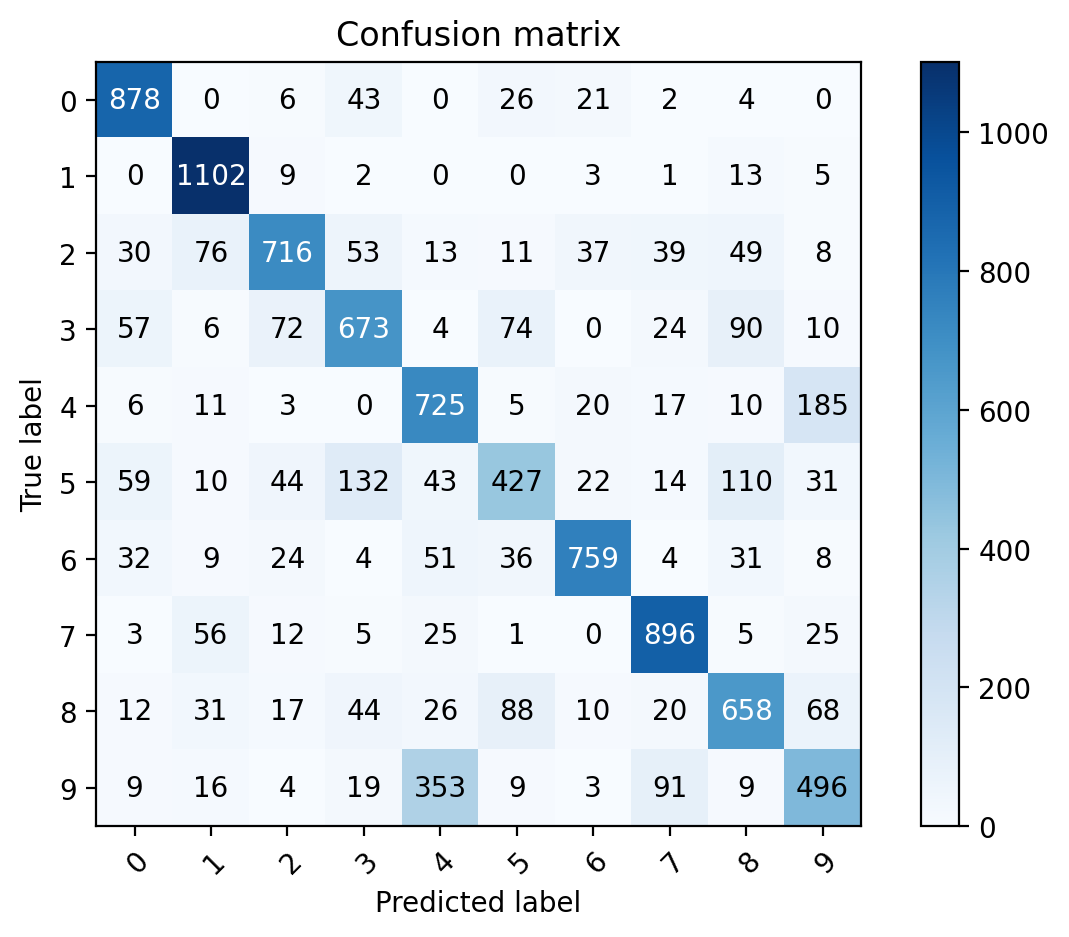

Training 4/5, Epoch 20/20, Train Loss: 0.6829, Test Loss: 0.8912, Test Accuracy: 0.7330
lr=0.027, n_h=256
Training 5/5, Epoch 1/20, Train Loss: 2.3043, Test Loss: 2.3026, Test Accuracy: 0.1027
Training 5/5, Epoch 2/20, Train Loss: 2.3053, Test Loss: 2.3022, Test Accuracy: 0.1135
Training 5/5, Epoch 3/20, Train Loss: 2.3063, Test Loss: 2.3020, Test Accuracy: 0.1135
Training 5/5, Epoch 4/20, Train Loss: 2.3073, Test Loss: 2.3018, Test Accuracy: 0.1135
Training 5/5, Epoch 5/20, Train Loss: 2.3082, Test Loss: 2.3016, Test Accuracy: 0.1135
Training 5/5, Epoch 6/20, Train Loss: 2.3091, Test Loss: 2.3015, Test Accuracy: 0.1135
Training 5/5, Epoch 7/20, Train Loss: 2.3100, Test Loss: 2.3014, Test Accuracy: 0.1135
Training 5/5, Epoch 8/20, Train Loss: 2.3108, Test Loss: 2.3013, Test Accuracy: 0.1135
Training 5/5, Epoch 9/20, Train Loss: 2.3116, Test Loss: 2.3012, Test Accuracy: 0.1135
Training 5/5, Epoch 10/20, Train Loss: 2.3123, Test Loss: 2.3012, Test Accuracy: 0.1135
Training 5/5, Epoch 11/

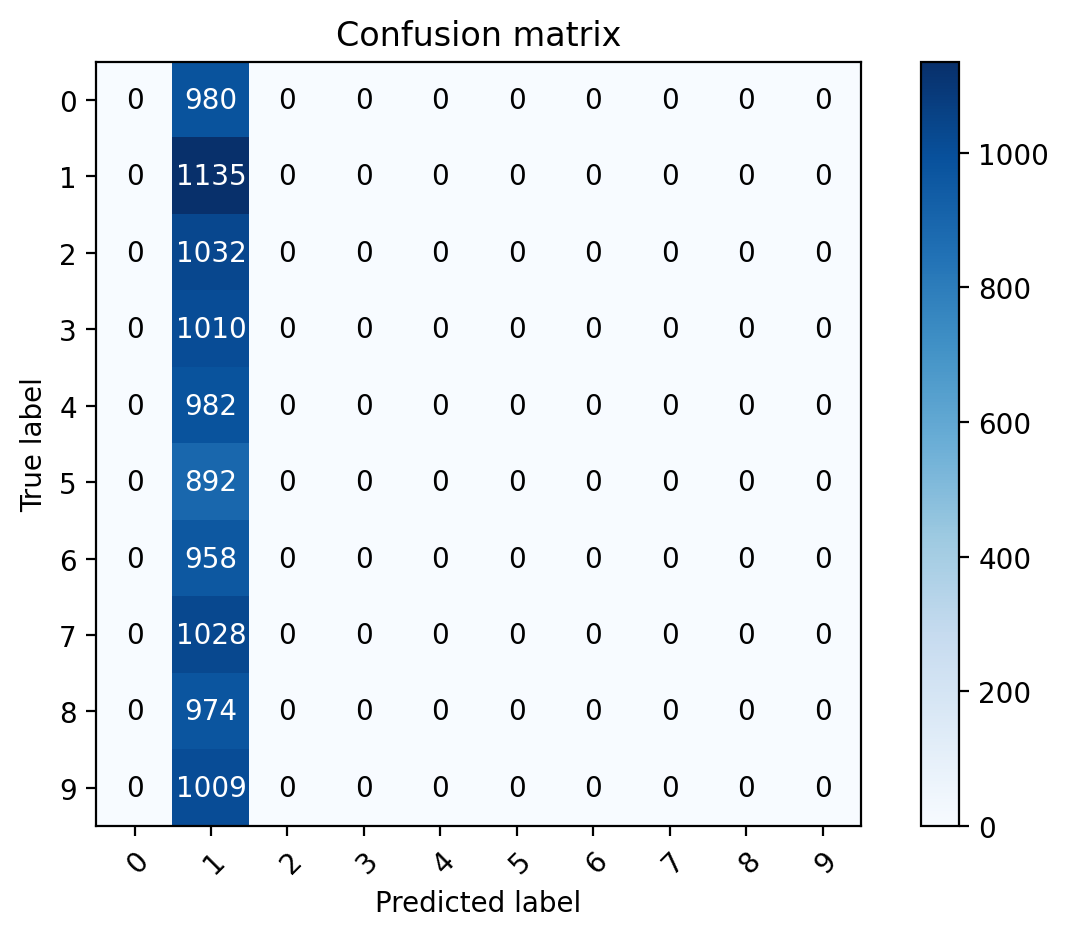

Training 5/5, Epoch 20/20, Train Loss: 2.3180, Test Loss: 2.3014, Test Accuracy: 0.1135


In [ ]:
num_trainings=5
epochs=20
labels, train_losses, test_losses, test_accuracies = \
    train_network(num_trainings=num_trainings, epochs=epochs, train_data=train_data, test_data=test_data)

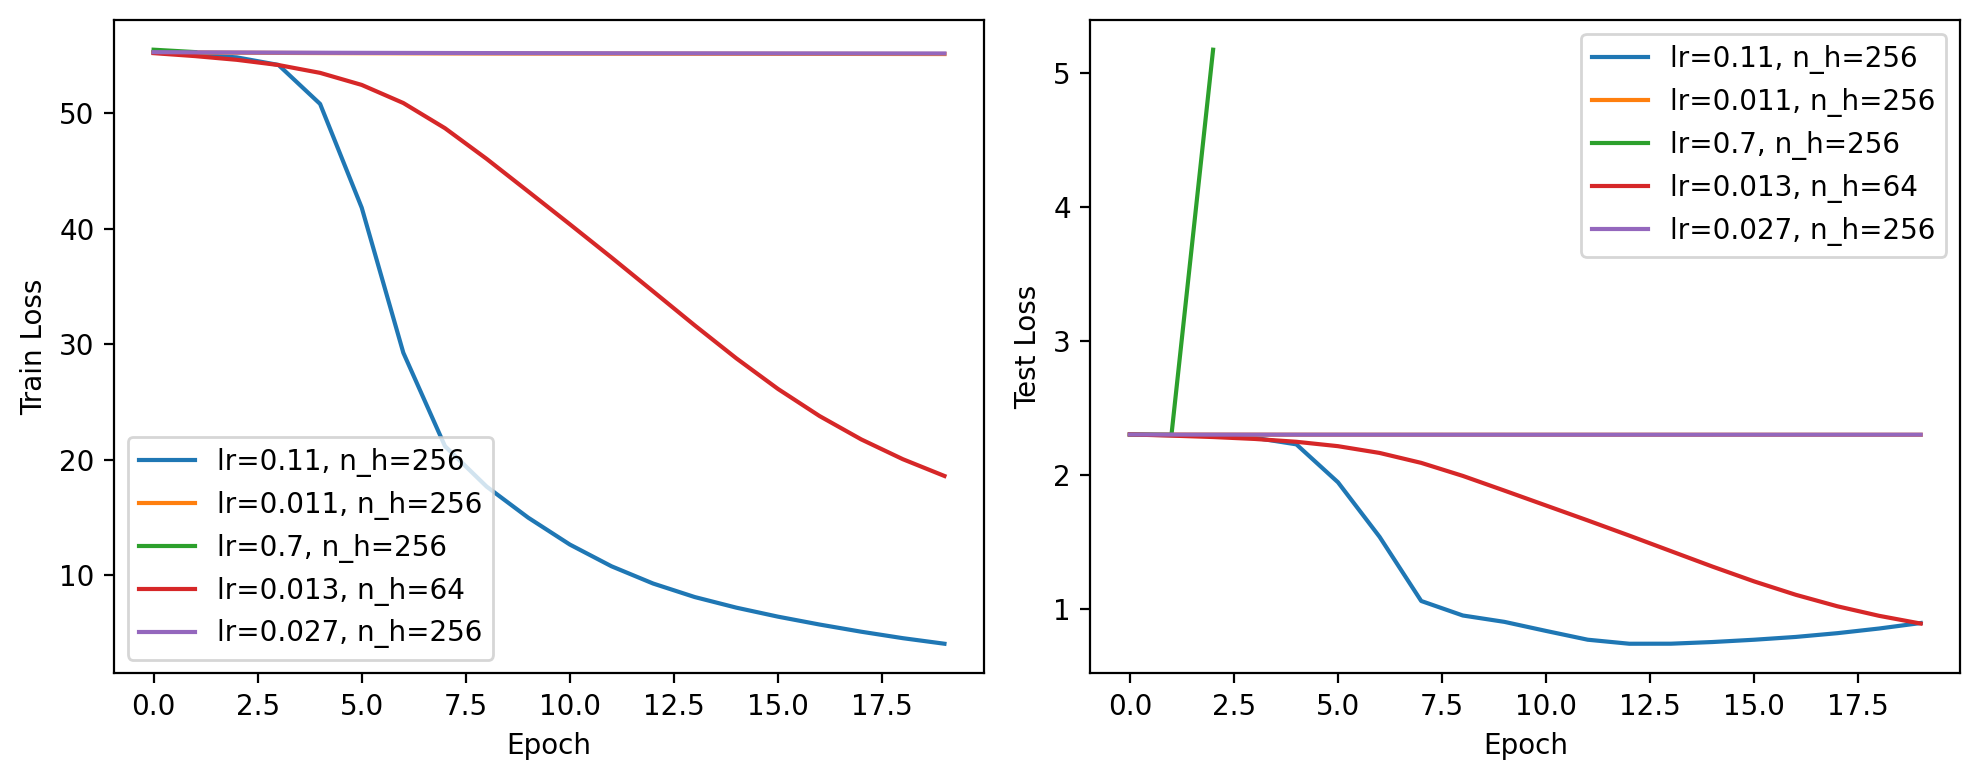

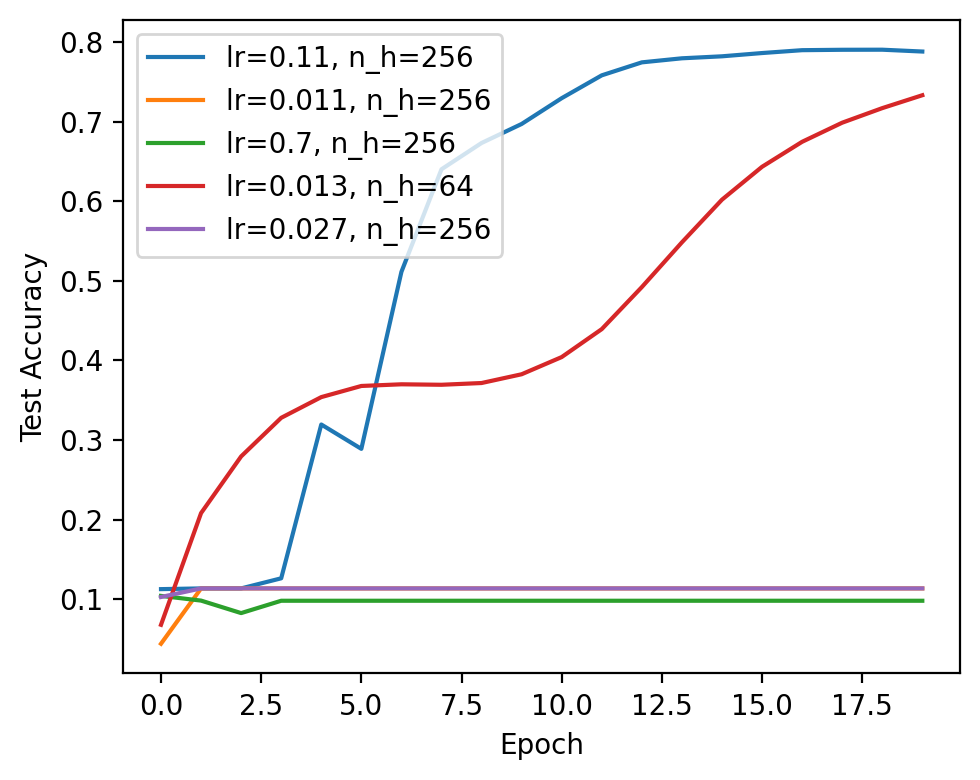

In [ ]:
plot_results(labels, train_losses, test_losses, test_accuracies)

Damit erhalten wir zumindest in manchen Fällen eine gute accuracy und confusion matrix mit ausgepraegter Diagonale.
In der Regel sind hohe learning rates $> 0.1$ und grosse hidden layer von Vorteil. Allerdings hat auch die Wahl der Gewichte beim erstellen des Netzwerks einen Einfluss auf das Ergebnis, da die Cross Entropy Loss nicht konvex ist und mehrere lokale Minima hat.

Zu den vielen Massnahmen, um die Performance dieses Netzwerks weiter zu verbessern, gehören
* Regularization um Gewichte klein zu halten
* bessere Optimierungsalgorithmen um lokale Minima schneller zu finden
* Activation Funktionen auf hidden layern

Bevor einige Massnahmen getroffen wurden, um das Training des Netzwerks stabiler zu machen, kann keine abschliessende Entscheidung über passende Hyperparameter getroffen werden, da fast identische Hyperparameter zum selben Ergebnis f.

## Zusammenfassung

In diesem Notebook haben wir Neuronale Netze entworfen und trainiert, um das MNIST Datenset von handgeschriebenen Ziffern korrekt zu klassifizieren.
Nachdem wir uns mit den Details des Datensets vertraut gemacht haben, implementierten wir ein Lineares Layer als Basisbaustein der Neuronalen Netze.
Damit haben wir zunächts ein einfaches Modell mit einem hidden Layer sowie einem output entworfen, im Bilder mit der Ziffer "4" zu identifizieren.
Dabei sind wir auf das Problem gestossen, dass nur jedes zehnte Bild eine 4 zeigt und durch das unbalanzierte Training das Modell lernt, nie eine 4 zu erkennen. Diesem Problem können wir mit Klassengewichtung oder oversampling begegnen.

Als nächstes haben wir ein tieferes Netzwerk mit 3 hidden Layern erstellt, um alle Ziffern korrekt zu klassifizieren. Dabei sind wir auf das Problem gestossen, dass gleichzeitiges trainieren auf allen Daten zum stagnieren des Modells führt. Durch das unterteilen des Trainings in kleinere Einheiten konnten wir dieses Problem beheben grundlegend beheben.

Zusammenfassend zeigt dieses Notebook einerseits, dass mithilfe von Neuronalen Netzwerken unterschiedliche, komplizierte Aufgaben mit der grundsätzlich gleichen Struktur geloest werden koennen. Allerdings können die Feinheiten, um diese Lösung zu einem optimalen Ergebnis zu führen, von Problem zu Problem sehr unterschiedlich sein.
Das Ziel dieser Arbeit war mathematisches Denken und Kommunikation im Anwendungsfall zu üben, nicht optimale Ergebnisse zu erzielen. Daher sind die hier vorgestellten Modelle weit entfernt von einem optimalen Ergebnis.

GPT3.5 wurde verwendet um:
* Die grobe Struktur der Abgabe zu planen
* Einzelne Funktionen zu erstellen
* Classes zu planen und prompts zu generieren um die enthaltenen Funktionen erstellen
* Dokumentation zu erstellen
* Funktionen zu debuggen
* Codes zusammenzufassen & umzuschreiben
Jeder code wurde urspruenglich von GPT geschrieben und nahezu ausschliesslich nach meinen Anweisungen durch GPT verbessert, bis auf wenige, geringfügige händische Änderungen.

Die Verwendung von GPT für diese Aufgabe hat mir gezeigt, dass es ein sehr nütliches Tool ist, was viele Arbeiten abnehmen und erleichtern kann. Insbesondere ist fuer diese Abgabe kein Pythonverständnis nötig, da GPT mühelos zwischen Python und Pseudocode übersetzt. Allerdings ersetzt es in keiner Weise ein Verständnis des Inhalts und vor allem kritisches und Zielgerichtetes Denken.
